### remember to change model saving path!!!

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

In [23]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [24]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor

In [100]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    if(random.random() < p):
        jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
        image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Gland_Dataset("../gland_data/benq_train_1.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Gland_Dataset("../gland_data/benq_test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask = next(iter(test_dataloader))

In [101]:
image.shape

torch.Size([103, 1, 128, 128])

In [102]:
print(len(train_dataset), len(test_dataset))

308 158


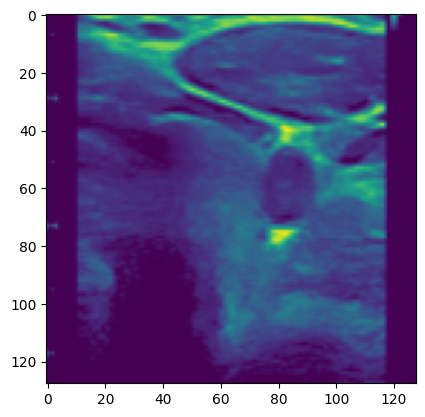

In [103]:
plt.imshow(image[18][0])

In [104]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        count+=1
        # if count==5:
        #     break
    return total_loss/count, total_IOU/count, total_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    conut = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        conut += 1
    return total_loss/conut, total_IOU/conut, total_DICE/conut


    

In [105]:

inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [106]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [107]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [108]:

project = "thyroid_gland_finetune"
name = "hybrid_model_gland_baseline(1)_freeze_encoder_wo_zeromask_aug_colorjitter_affine"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [109]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [110]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/gland/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/gland/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/gland/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 1.7224104404449463, train IOU : 0.12812112520138422, train DICE : 0.2718484203020732


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 1.3965287804603577, val IOU : 0.03374800831079483, val DICE : 0.11263647675514221
epoch : 1


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 1.1676404476165771, train IOU : 0.27468696733315784, train DICE : 0.4119235078493754


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 1.0094858407974243, val IOU : 0.22277037054300308, val DICE : 0.3950474262237549
epoch : 2


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.7804039518038431, train IOU : 0.48493621746699017, train DICE : 0.594285249710083


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.7316804826259613, val IOU : 0.4594971090555191, val DICE : 0.6157437562942505
epoch : 3


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.6506451368331909, train IOU : 0.5571893453598022, train DICE : 0.665215015411377


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.615007072687149, val IOU : 0.5494785010814667, val DICE : 0.6791473031044006
epoch : 4


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.6352006196975708, train IOU : 0.5711735089619955, train DICE : 0.6762835184733073


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.5708430707454681, val IOU : 0.5774458348751068, val DICE : 0.7000663578510284
epoch : 5


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.5802801251411438, train IOU : 0.6065670450528463, train DICE : 0.7083460291226705


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5638306736946106, val IOU : 0.5892812311649323, val DICE : 0.7147374749183655
epoch : 6


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.5674422184626261, train IOU : 0.6416117747624716, train DICE : 0.7309774955113729


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5463147014379501, val IOU : 0.601457953453064, val DICE : 0.7162889242172241
epoch : 7


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.5137317975362142, train IOU : 0.6630285382270813, train DICE : 0.7462593714396158


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5410603135824203, val IOU : 0.6008729934692383, val DICE : 0.7145852744579315
epoch : 8


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.5079145828882853, train IOU : 0.6808006763458252, train DICE : 0.7543134291966757


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.5337170213460922, val IOU : 0.6015670001506805, val DICE : 0.7155497968196869
epoch : 9


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.47531195481618244, train IOU : 0.6993154287338257, train DICE : 0.7651840051015218


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5266263335943222, val IOU : 0.600688636302948, val DICE : 0.7134777009487152
epoch : 10


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.48027363419532776, train IOU : 0.7066585818926493, train DICE : 0.7672445376714071


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5206577330827713, val IOU : 0.6006685197353363, val DICE : 0.7121216654777527
epoch : 11


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.45473499099413556, train IOU : 0.7081242203712463, train DICE : 0.7773917317390442


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5148391872644424, val IOU : 0.6029799580574036, val DICE : 0.7126009166240692
epoch : 12


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.45359163482983905, train IOU : 0.7181917826334635, train DICE : 0.7802343964576721


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.510336384177208, val IOU : 0.6078394651412964, val DICE : 0.71519935131073
epoch : 13


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.43466782569885254, train IOU : 0.7315995693206787, train DICE : 0.7909994522730509


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.5074582695960999, val IOU : 0.610401839017868, val DICE : 0.717499166727066
epoch : 14


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.4197516143321991, train IOU : 0.7298250397046407, train DICE : 0.7965439756711324


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.5021828860044479, val IOU : 0.6150533556938171, val DICE : 0.7211160659790039
epoch : 15


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.41912699739138287, train IOU : 0.7446862459182739, train DICE : 0.8007647593816122


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.49998798966407776, val IOU : 0.6151075065135956, val DICE : 0.7217060625553131
epoch : 16


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.40546648701032, train IOU : 0.7464992801348368, train DICE : 0.8082341154416403


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.498544305562973, val IOU : 0.6143734455108643, val DICE : 0.7223920822143555
epoch : 17


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.3972066044807434, train IOU : 0.7525735298792521, train DICE : 0.8138047258059183


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.49202486872673035, val IOU : 0.6203959584236145, val DICE : 0.7284957468509674
epoch : 18


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.38908294836680096, train IOU : 0.7619554400444031, train DICE : 0.8185083866119385


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.48491764068603516, val IOU : 0.6287147104740143, val DICE : 0.7352720499038696
epoch : 19


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.3661338885625203, train IOU : 0.7721386750539144, train DICE : 0.8305552999178568


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.47999848425388336, val IOU : 0.6305455267429352, val DICE : 0.7365937829017639
epoch : 20


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.3892487585544586, train IOU : 0.7636016607284546, train DICE : 0.8206655383110046


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.48038484156131744, val IOU : 0.6260798871517181, val DICE : 0.7329502403736115
epoch : 21


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.3610520561536153, train IOU : 0.7743502259254456, train DICE : 0.8308571577072144


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.48373091220855713, val IOU : 0.6215876638889313, val DICE : 0.729879766702652
epoch : 22


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.35790136456489563, train IOU : 0.775873084863027, train DICE : 0.8339341282844543


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.48122894763946533, val IOU : 0.6246489584445953, val DICE : 0.7335962653160095
epoch : 23


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.36127803723017377, train IOU : 0.7839613755544027, train DICE : 0.8364829421043396


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4737963527441025, val IOU : 0.6351984441280365, val DICE : 0.7435919046401978
epoch : 24


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.3480895757675171, train IOU : 0.7892692883809408, train DICE : 0.8424685597419739


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.46938128769397736, val IOU : 0.6352354288101196, val DICE : 0.7447916567325592
epoch : 25


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.3345559537410736, train IOU : 0.7925242781639099, train DICE : 0.8486736019452413


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4614144563674927, val IOU : 0.6412200629711151, val DICE : 0.7482890784740448
epoch : 26


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.33127816518147785, train IOU : 0.7988001505533854, train DICE : 0.849887490272522


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4554893374443054, val IOU : 0.647390216588974, val DICE : 0.753654271364212
epoch : 27


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.3365076680978139, train IOU : 0.7922365864117941, train DICE : 0.8456176519393921


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4535949230194092, val IOU : 0.6508412063121796, val DICE : 0.7580154836177826
epoch : 28


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.32855163017908734, train IOU : 0.7943739493687948, train DICE : 0.8514930208524069


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4513579457998276, val IOU : 0.6586030125617981, val DICE : 0.7638197541236877
epoch : 29


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.3096674581368764, train IOU : 0.8078352808952332, train DICE : 0.8600783944129944


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.45164185762405396, val IOU : 0.6576654613018036, val DICE : 0.7630391418933868
epoch : 30


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.32060888409614563, train IOU : 0.8001967668533325, train DICE : 0.8534732460975647


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.44881659746170044, val IOU : 0.6564605236053467, val DICE : 0.7595010101795197
epoch : 31


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.30024604002634686, train IOU : 0.8128377199172974, train DICE : 0.8652939597765604


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.43793918192386627, val IOU : 0.6662087142467499, val DICE : 0.7652539908885956
epoch : 32


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.29472533861796063, train IOU : 0.8173407117525736, train DICE : 0.8694335023562113


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.427919402718544, val IOU : 0.6756539940834045, val DICE : 0.773199588060379
epoch : 33


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.2960488299528758, train IOU : 0.8193507393201193, train DICE : 0.8730082313219706


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4320634454488754, val IOU : 0.6700169742107391, val DICE : 0.771944671869278
epoch : 34


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2976059416929881, train IOU : 0.8104609449704488, train DICE : 0.8654778202374777


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4317471385002136, val IOU : 0.6719265282154083, val DICE : 0.7723116278648376
epoch : 35


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.30229950944582623, train IOU : 0.817452073097229, train DICE : 0.8649744788805643


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.42716874182224274, val IOU : 0.6757137477397919, val DICE : 0.7741663455963135
epoch : 36


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2979638973871867, train IOU : 0.8202191988627116, train DICE : 0.8702868620554606


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.42709387838840485, val IOU : 0.6709456443786621, val DICE : 0.7701476812362671
epoch : 37


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2835284074147542, train IOU : 0.8169464468955994, train DICE : 0.872890849908193


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4220430999994278, val IOU : 0.6794259548187256, val DICE : 0.7778328359127045
epoch : 38


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.2980003257592519, train IOU : 0.820133646329244, train DICE : 0.8709010283152262


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.42402219772338867, val IOU : 0.6829085648059845, val DICE : 0.7812220752239227
epoch : 39


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2850303252538045, train IOU : 0.8224257826805115, train DICE : 0.8748764594395956


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.43118633329868317, val IOU : 0.666052907705307, val DICE : 0.7680197358131409
epoch : 40


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2881808280944824, train IOU : 0.8225806752840678, train DICE : 0.875383218129476


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.42540036141872406, val IOU : 0.6727978885173798, val DICE : 0.7716882526874542
epoch : 41


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.27878238757451373, train IOU : 0.8296534220377604, train DICE : 0.8768550356229147


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4210614711046219, val IOU : 0.6777390837669373, val DICE : 0.7754592001438141
epoch : 42


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2695998152097066, train IOU : 0.8277942538261414, train DICE : 0.8848120967547098


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.41656503081321716, val IOU : 0.6821166276931763, val DICE : 0.7767223417758942
epoch : 43


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2827993631362915, train IOU : 0.8225738803545634, train DICE : 0.8750080664952596


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.41277948021888733, val IOU : 0.6861446797847748, val DICE : 0.7803882658481598
epoch : 44


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2858644823233287, train IOU : 0.8240317304929098, train DICE : 0.8724151055018107


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4103998839855194, val IOU : 0.6887740790843964, val DICE : 0.7876981794834137
epoch : 45


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.27651270230611164, train IOU : 0.8297880093256632, train DICE : 0.8790753285090128


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4031417667865753, val IOU : 0.697942316532135, val DICE : 0.7920287549495697
epoch : 46


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.26729369163513184, train IOU : 0.8331377108891805, train DICE : 0.884431004524231


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4134186804294586, val IOU : 0.678639829158783, val DICE : 0.7766749560832977
epoch : 47


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2671453356742859, train IOU : 0.8352600932121277, train DICE : 0.8809209863344828


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.4173235297203064, val IOU : 0.6791222095489502, val DICE : 0.7789177894592285
epoch : 48


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2644060452779134, train IOU : 0.839353104432424, train DICE : 0.8901393214861552


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.4084077775478363, val IOU : 0.6893801391124725, val DICE : 0.7860207259654999
epoch : 49


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.2594836354255676, train IOU : 0.8349683284759521, train DICE : 0.8857417503992716


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3988437205553055, val IOU : 0.6961560249328613, val DICE : 0.788835197687149
epoch : 50


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2702513535817464, train IOU : 0.8353838523228964, train DICE : 0.8845701416333517


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3970939964056015, val IOU : 0.6959711015224457, val DICE : 0.7912963330745697
epoch : 51


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.24802079796791077, train IOU : 0.8408540487289429, train DICE : 0.892470141251882


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.40599676966667175, val IOU : 0.6865117251873016, val DICE : 0.7846810221672058
epoch : 52


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.26824337244033813, train IOU : 0.8423521916071574, train DICE : 0.8896069924036661


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4047428369522095, val IOU : 0.688185840845108, val DICE : 0.7863513827323914
epoch : 53


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.260441521803538, train IOU : 0.8314504822095236, train DICE : 0.8863934477170309


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3912689685821533, val IOU : 0.7054038643836975, val DICE : 0.7959899604320526
epoch : 54


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.26183053851127625, train IOU : 0.8355739116668701, train DICE : 0.8893124262491862


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39194001257419586, val IOU : 0.7110408842563629, val DICE : 0.797453910112381
epoch : 55


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2479497641324997, train IOU : 0.8458898862202963, train DICE : 0.8948727051417033


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4116112291812897, val IOU : 0.6856624186038971, val DICE : 0.7797669768333435
epoch : 56


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.25704572598139447, train IOU : 0.8451828956604004, train DICE : 0.8931229511896769


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.40185272693634033, val IOU : 0.6950457096099854, val DICE : 0.7892684042453766
epoch : 57


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2479733576377233, train IOU : 0.8467627167701721, train DICE : 0.8958357373873392


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3978208154439926, val IOU : 0.6971924006938934, val DICE : 0.7942255139350891
epoch : 58


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2520469029744466, train IOU : 0.84013698498408, train DICE : 0.8894094427426656


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.40342941880226135, val IOU : 0.6867206394672394, val DICE : 0.7834078073501587
epoch : 59


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.25645174582799274, train IOU : 0.8415460785230001, train DICE : 0.8897722363471985


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3972676396369934, val IOU : 0.6937407851219177, val DICE : 0.7878892123699188
epoch : 60


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.24914544820785522, train IOU : 0.848780075709025, train DICE : 0.8960667649904887


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39411894977092743, val IOU : 0.6979707181453705, val DICE : 0.795229434967041
epoch : 61


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2542217820882797, train IOU : 0.8402794400850931, train DICE : 0.8905945618947347


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3911054730415344, val IOU : 0.7063862085342407, val DICE : 0.8001598119735718
epoch : 62


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2450682371854782, train IOU : 0.8449988762537638, train DICE : 0.8942329088846842


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3936941474676132, val IOU : 0.7090210914611816, val DICE : 0.7995207011699677
epoch : 63


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.252876212199529, train IOU : 0.8445141514142355, train DICE : 0.8941574096679688


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4095749408006668, val IOU : 0.6936982572078705, val DICE : 0.7920849323272705
epoch : 64


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.25003766516844433, train IOU : 0.8494420647621155, train DICE : 0.8986839652061462


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.4007480591535568, val IOU : 0.7003796100616455, val DICE : 0.7998732924461365
epoch : 65


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.23866449296474457, train IOU : 0.8507515788078308, train DICE : 0.8987169663111368


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39248377084732056, val IOU : 0.7067082226276398, val DICE : 0.8025447726249695
epoch : 66


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


train loss : 0.23395076394081116, train IOU : 0.8546974261601766, train DICE : 0.9018338322639465


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39003849029541016, val IOU : 0.7080364227294922, val DICE : 0.7995148599147797
epoch : 67


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.24944338202476501, train IOU : 0.8498026728630066, train DICE : 0.8968402544657389


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.39869697391986847, val IOU : 0.6923227608203888, val DICE : 0.7855062484741211
epoch : 68


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.23717553913593292, train IOU : 0.8525417049725851, train DICE : 0.9005715052286783


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3970240652561188, val IOU : 0.6975917220115662, val DICE : 0.789371520280838
epoch : 69


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


train loss : 0.24310807387034097, train IOU : 0.8440373142560323, train DICE : 0.8923904498418173


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39931929111480713, val IOU : 0.6961692869663239, val DICE : 0.788737416267395
epoch : 70


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.23416926463445029, train IOU : 0.8575290242830912, train DICE : 0.9012635548909506


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.4060015231370926, val IOU : 0.6900157034397125, val DICE : 0.7852292954921722
epoch : 71


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.24264482160409293, train IOU : 0.8482900063196818, train DICE : 0.8961572051048279


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3974945396184921, val IOU : 0.7047822773456573, val DICE : 0.79624342918396
epoch : 72


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.23644956449667612, train IOU : 0.855469266573588, train DICE : 0.902616818745931


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3870619088411331, val IOU : 0.7127368748188019, val DICE : 0.8009330034255981
epoch : 73


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.23823364078998566, train IOU : 0.8518458803494772, train DICE : 0.900320808092753


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3913385570049286, val IOU : 0.6993567645549774, val DICE : 0.7945384979248047
epoch : 74


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.23782351116339365, train IOU : 0.8518171509106954, train DICE : 0.9020471970240275


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.392344668507576, val IOU : 0.7088234126567841, val DICE : 0.8018909990787506
epoch : 75


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.23306282858053842, train IOU : 0.858066976070404, train DICE : 0.9052061637242635


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3940303474664688, val IOU : 0.7023293077945709, val DICE : 0.794859766960144
epoch : 76


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.23133314152558646, train IOU : 0.8568994204203287, train DICE : 0.9078818162282308


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3833858370780945, val IOU : 0.7092033922672272, val DICE : 0.8007039427757263
epoch : 77


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.2290611763795217, train IOU : 0.8580330808957418, train DICE : 0.9055749177932739


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3855346739292145, val IOU : 0.7073895335197449, val DICE : 0.8012430369853973
epoch : 78


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.2370465894540151, train IOU : 0.852898120880127, train DICE : 0.9015476306279501


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39654316008090973, val IOU : 0.6947513818740845, val DICE : 0.7897360324859619
epoch : 79


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.23358757297197977, train IOU : 0.853753407796224, train DICE : 0.9016909996668497


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38669344782829285, val IOU : 0.7146859169006348, val DICE : 0.8014658391475677
epoch : 80


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.23515659073988596, train IOU : 0.8611480394999186, train DICE : 0.9053060015042623


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3878006041049957, val IOU : 0.7052831053733826, val DICE : 0.7994832098484039
epoch : 81


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.22862874468167624, train IOU : 0.8605141639709473, train DICE : 0.9081323345502218


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.39654986560344696, val IOU : 0.6889798641204834, val DICE : 0.7891422212123871
epoch : 82


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.22746298213799795, train IOU : 0.8589872519175211, train DICE : 0.9066242178281149


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39993709325790405, val IOU : 0.6890113055706024, val DICE : 0.7838036119937897
epoch : 83


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.23378634452819824, train IOU : 0.8594754934310913, train DICE : 0.9052573641141256


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39139941334724426, val IOU : 0.6986308991909027, val DICE : 0.7940754592418671
epoch : 84


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2337192247311274, train IOU : 0.8545093933741251, train DICE : 0.9042404691378275


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38631612062454224, val IOU : 0.7160363495349884, val DICE : 0.8082978427410126
epoch : 85


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.223603293299675, train IOU : 0.8621039986610413, train DICE : 0.908005972703298


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.4001414626836777, val IOU : 0.7055087983608246, val DICE : 0.7985112071037292
epoch : 86


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2334837019443512, train IOU : 0.8589463035265604, train DICE : 0.9050052563349406


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4018018990755081, val IOU : 0.6967980563640594, val DICE : 0.7928998470306396
epoch : 87


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.22610661884148917, train IOU : 0.8600732684135437, train DICE : 0.9073670705159506


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38575316965579987, val IOU : 0.7051907777786255, val DICE : 0.7999664843082428
epoch : 88


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.21945327520370483, train IOU : 0.866057276725769, train DICE : 0.9115752975145975


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3820247948169708, val IOU : 0.7039367854595184, val DICE : 0.7981445491313934
epoch : 89


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.22423098484675089, train IOU : 0.8576304912567139, train DICE : 0.9034953117370605


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38685643672943115, val IOU : 0.707457423210144, val DICE : 0.8006469011306763
epoch : 90


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.2164694368839264, train IOU : 0.8679799834887186, train DICE : 0.9127194484074911


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3916156440973282, val IOU : 0.7077023983001709, val DICE : 0.8009236752986908
epoch : 91


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2205346922079722, train IOU : 0.8659858703613281, train DICE : 0.911653975645701


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39422427117824554, val IOU : 0.6950887441635132, val DICE : 0.7946135401725769
epoch : 92


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.22477271656195322, train IOU : 0.8579440712928772, train DICE : 0.90525883436203


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3923121243715286, val IOU : 0.7018943428993225, val DICE : 0.7974697351455688
epoch : 93


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.21914474169413248, train IOU : 0.8666913509368896, train DICE : 0.9119642376899719


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.4125257581472397, val IOU : 0.6855398714542389, val DICE : 0.785930871963501
epoch : 94


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.2247204383214315, train IOU : 0.8617621461550394, train DICE : 0.9096896449724833


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3965388238430023, val IOU : 0.7021855115890503, val DICE : 0.797920823097229
epoch : 95


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.20960510770479837, train IOU : 0.8677756388982137, train DICE : 0.9147434234619141


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3854561895132065, val IOU : 0.7082086503505707, val DICE : 0.8021554350852966
epoch : 96


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.21567527949810028, train IOU : 0.8674465616544088, train DICE : 0.9131802717844645


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3887140303850174, val IOU : 0.7035762369632721, val DICE : 0.8014349937438965
epoch : 97


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.23191653688748678, train IOU : 0.861879845460256, train DICE : 0.9083860516548157


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3898763656616211, val IOU : 0.7057167589664459, val DICE : 0.8034392893314362
epoch : 98


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.21261834104855856, train IOU : 0.8653004964192709, train DICE : 0.9133044083913168


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3988339453935623, val IOU : 0.6983416080474854, val DICE : 0.7938268184661865
epoch : 99


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.21988550821940103, train IOU : 0.8627076745033264, train DICE : 0.9091895620028178


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39151255786418915, val IOU : 0.7072515189647675, val DICE : 0.7985967993736267
epoch : 100


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.2229864796002706, train IOU : 0.8661104043324789, train DICE : 0.9100374976793925


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39141054451465607, val IOU : 0.7001489400863647, val DICE : 0.7982936501502991
epoch : 101


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.21292424698670706, train IOU : 0.8674483100573221, train DICE : 0.9121716817220052


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.37693363428115845, val IOU : 0.7160106599330902, val DICE : 0.809317409992218
epoch : 102


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.21544152001539865, train IOU : 0.8677594065666199, train DICE : 0.913163423538208


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3816806375980377, val IOU : 0.7202238142490387, val DICE : 0.8117471933364868
epoch : 103


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.21671153604984283, train IOU : 0.86639537413915, train DICE : 0.9103243947029114


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38337840139865875, val IOU : 0.717833936214447, val DICE : 0.8105293214321136
epoch : 104


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.2112395167350769, train IOU : 0.874032219250997, train DICE : 0.9164358377456665


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3908425122499466, val IOU : 0.7050352692604065, val DICE : 0.7969389259815216
epoch : 105


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.21829050282637277, train IOU : 0.8649628559748331, train DICE : 0.912855327129364


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3909226804971695, val IOU : 0.7022605240345001, val DICE : 0.7954271137714386
epoch : 106


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.21677446365356445, train IOU : 0.8672820329666138, train DICE : 0.9122050801912943


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3864671140909195, val IOU : 0.7060600519180298, val DICE : 0.7973206639289856
epoch : 107


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.20677691201368967, train IOU : 0.8725695411364237, train DICE : 0.9143877228101095


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3952019363641739, val IOU : 0.6911197006702423, val DICE : 0.7906002700328827
epoch : 108


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.20665831367174783, train IOU : 0.8755591114362081, train DICE : 0.9178346395492554


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38965217769145966, val IOU : 0.6988337635993958, val DICE : 0.7995441257953644
epoch : 109


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.20524432758490244, train IOU : 0.8728135029474894, train DICE : 0.9178808331489563


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38197319209575653, val IOU : 0.7079294323921204, val DICE : 0.8057661652565002
epoch : 110


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2128383368253708, train IOU : 0.8679835995038351, train DICE : 0.9149799942970276


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38391780853271484, val IOU : 0.7219422161579132, val DICE : 0.8149384260177612
epoch : 111


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.20050530632336935, train IOU : 0.8779703577359518, train DICE : 0.9176112413406372


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39624233543872833, val IOU : 0.7048580646514893, val DICE : 0.8033874034881592
epoch : 112


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.21032120287418365, train IOU : 0.8672175606091818, train DICE : 0.914777417977651


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.37991926074028015, val IOU : 0.718286395072937, val DICE : 0.8104861974716187
epoch : 113


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.20934468507766724, train IOU : 0.8704778552055359, train DICE : 0.9153090715408325


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3795124888420105, val IOU : 0.7057634592056274, val DICE : 0.8043339550495148
epoch : 114


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.20390660564104715, train IOU : 0.8693416118621826, train DICE : 0.9173558354377747


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.37614113092422485, val IOU : 0.7139068841934204, val DICE : 0.8113600611686707
epoch : 115


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.2142255703608195, train IOU : 0.8699303865432739, train DICE : 0.9157850742340088


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38387924432754517, val IOU : 0.7058093547821045, val DICE : 0.8046946227550507
epoch : 116


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.21755147476991019, train IOU : 0.8686965505282084, train DICE : 0.9123637477556864


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38563358783721924, val IOU : 0.7076667845249176, val DICE : 0.8031416535377502
epoch : 117


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2246279219786326, train IOU : 0.867178479830424, train DICE : 0.9122110406557719


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38546910881996155, val IOU : 0.7123775482177734, val DICE : 0.8055234551429749
epoch : 118


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.21512924631436667, train IOU : 0.8631898562113444, train DICE : 0.9132319490114847


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38751938939094543, val IOU : 0.7032900154590607, val DICE : 0.8003166317939758
epoch : 119


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2059000035127004, train IOU : 0.8749081095059713, train DICE : 0.9188039302825928


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38165469467639923, val IOU : 0.7086226642131805, val DICE : 0.809685230255127
epoch : 120


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.21825343370437622, train IOU : 0.8654693166414896, train DICE : 0.9135377407073975


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3871273994445801, val IOU : 0.7033785581588745, val DICE : 0.806622326374054
epoch : 121


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.20791521668434143, train IOU : 0.8763261636098226, train DICE : 0.9174234469731649


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38546445965766907, val IOU : 0.7104811370372772, val DICE : 0.8089984357357025
epoch : 122


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2100850244363149, train IOU : 0.8677029609680176, train DICE : 0.9126738508542379


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3850596696138382, val IOU : 0.7106355726718903, val DICE : 0.806191623210907
epoch : 123


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.21351841588815054, train IOU : 0.8697373072306315, train DICE : 0.9147640069325765


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3884689211845398, val IOU : 0.7024382948875427, val DICE : 0.7990086376667023
epoch : 124


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.21232732633749643, train IOU : 0.8669055104255676, train DICE : 0.9121875564257304


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39046257734298706, val IOU : 0.7057611346244812, val DICE : 0.8032443523406982
epoch : 125


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2045128494501114, train IOU : 0.8763007322947184, train DICE : 0.921662429968516


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38893716037273407, val IOU : 0.7023108005523682, val DICE : 0.7977216243743896
epoch : 126


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.20277468860149384, train IOU : 0.8754033843676249, train DICE : 0.9173404773076376


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3855283409357071, val IOU : 0.7019182741641998, val DICE : 0.7967444658279419
epoch : 127


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.20474067330360413, train IOU : 0.8743781844774882, train DICE : 0.9196886221567789


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.370006263256073, val IOU : 0.7225061058998108, val DICE : 0.8112829923629761
epoch : 128


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


train loss : 0.20331393678983053, train IOU : 0.8761257727940878, train DICE : 0.9193819165229797


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.38305191695690155, val IOU : 0.7104601263999939, val DICE : 0.8059614896774292
epoch : 129


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


train loss : 0.2093833088874817, train IOU : 0.8700762391090393, train DICE : 0.9152673482894897


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


val loss : 0.3820773661136627, val IOU : 0.714484840631485, val DICE : 0.8080140352249146
epoch : 130


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


train loss : 0.2053892860809962, train IOU : 0.8723378578821818, train DICE : 0.9158235589663187


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


val loss : 0.3803712874650955, val IOU : 0.7126094698905945, val DICE : 0.8098782002925873
epoch : 131


100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


train loss : 0.20238220691680908, train IOU : 0.8727102875709534, train DICE : 0.916973610719045


100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


val loss : 0.3776859790086746, val IOU : 0.7159714996814728, val DICE : 0.8099758625030518
epoch : 132


100%|██████████| 3/3 [00:07<00:00,  2.62s/it]


train loss : 0.20242019991079965, train IOU : 0.8804052074750265, train DICE : 0.9214289784431458


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.3866274654865265, val IOU : 0.7039812803268433, val DICE : 0.8044539093971252
epoch : 133


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


train loss : 0.20279474556446075, train IOU : 0.8732285499572754, train DICE : 0.9201528032620748


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.3823730945587158, val IOU : 0.7163821160793304, val DICE : 0.8108512461185455
epoch : 134


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.2140690286954244, train IOU : 0.8728399475415548, train DICE : 0.9132756590843201


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3882405012845993, val IOU : 0.7079589068889618, val DICE : 0.8037122786045074
epoch : 135


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.20694627364476523, train IOU : 0.8738498091697693, train DICE : 0.9178045988082886


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3781116455793381, val IOU : 0.7166565954685211, val DICE : 0.81083944439888
epoch : 136


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.20683489739894867, train IOU : 0.8707070748011271, train DICE : 0.919387956460317


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.36588481068611145, val IOU : 0.7320131957530975, val DICE : 0.8235411047935486
epoch : 137


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.20809893310070038, train IOU : 0.8687392274538676, train DICE : 0.9134887258211771


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3794225752353668, val IOU : 0.717962771654129, val DICE : 0.8130902945995331
epoch : 138


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.19592198729515076, train IOU : 0.877760112285614, train DICE : 0.9218219717343649


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3878484517335892, val IOU : 0.7101007401943207, val DICE : 0.8065671324729919
epoch : 139


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.19786875943342844, train IOU : 0.8787323435147604, train DICE : 0.9206836024920145


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3815242052078247, val IOU : 0.7209573686122894, val DICE : 0.8154954612255096
epoch : 140


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1990616371234258, train IOU : 0.8793941338857015, train DICE : 0.9206258257230123


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38570213317871094, val IOU : 0.7138127684593201, val DICE : 0.8091618716716766
epoch : 141


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.20418996612230936, train IOU : 0.8749524553616842, train DICE : 0.9184342424074808


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.39275187253952026, val IOU : 0.6995627582073212, val DICE : 0.7946087718009949
epoch : 142


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.1931674381097158, train IOU : 0.8817012310028076, train DICE : 0.9236820737520853


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.3851257562637329, val IOU : 0.7049794793128967, val DICE : 0.7985009849071503
epoch : 143


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.2039852887392044, train IOU : 0.8772034247716268, train DICE : 0.9213095903396606


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39088721573352814, val IOU : 0.7055661976337433, val DICE : 0.8029058277606964
epoch : 144


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.20229089756806692, train IOU : 0.8767824172973633, train DICE : 0.9200668533643087


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3906332403421402, val IOU : 0.7136486768722534, val DICE : 0.8079573214054108
epoch : 145


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.19740103681882223, train IOU : 0.8797571261723837, train DICE : 0.920849064985911


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38230542838573456, val IOU : 0.7170134484767914, val DICE : 0.8087462186813354
epoch : 146


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.2057137986024221, train IOU : 0.8773406545321146, train DICE : 0.9181288679440817


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38145722448825836, val IOU : 0.710641086101532, val DICE : 0.80522221326828
epoch : 147


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.19049075742562613, train IOU : 0.881713330745697, train DICE : 0.9266493717829386


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.37968210875988007, val IOU : 0.7161695063114166, val DICE : 0.8097421228885651
epoch : 148


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1999023954073588, train IOU : 0.8794174591700236, train DICE : 0.9214872320493063


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.37951214611530304, val IOU : 0.7203347086906433, val DICE : 0.809583842754364
epoch : 149


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.19205810129642487, train IOU : 0.8825585643450419, train DICE : 0.9228249589602152


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.37895698845386505, val IOU : 0.7219865918159485, val DICE : 0.8132955431938171
epoch : 150


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.19557487467924753, train IOU : 0.8812211155891418, train DICE : 0.9211437702178955


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3862062841653824, val IOU : 0.7118428945541382, val DICE : 0.8091631531715393
epoch : 151


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.20289477705955505, train IOU : 0.8721140225728353, train DICE : 0.9177918831507365


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3856610655784607, val IOU : 0.7081896960735321, val DICE : 0.8084484040737152
epoch : 152


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.20034063855806986, train IOU : 0.8783082167307535, train DICE : 0.9202138185501099


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3814503848552704, val IOU : 0.7120728492736816, val DICE : 0.8074815571308136
epoch : 153


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.19221782187620798, train IOU : 0.8810123999913534, train DICE : 0.9218284289042155


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38157905638217926, val IOU : 0.7111188173294067, val DICE : 0.8082010447978973
epoch : 154


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1926665405432383, train IOU : 0.8795730670293173, train DICE : 0.923795203367869


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3819461166858673, val IOU : 0.7126155495643616, val DICE : 0.8074392676353455
epoch : 155


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.20177801450093588, train IOU : 0.8772939840952555, train DICE : 0.920769194761912


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.382218673825264, val IOU : 0.7119930982589722, val DICE : 0.8080965876579285
epoch : 156


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.19495737055937448, train IOU : 0.880173921585083, train DICE : 0.9246138334274292


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39135612547397614, val IOU : 0.7182078063488007, val DICE : 0.8135319352149963
epoch : 157


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.20344645778338113, train IOU : 0.8755199114481608, train DICE : 0.9198775291442871


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39135195314884186, val IOU : 0.7051482498645782, val DICE : 0.8035069704055786
epoch : 158


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.189475287993749, train IOU : 0.8824992974599203, train DICE : 0.923344075679779


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.38500504195690155, val IOU : 0.7018643021583557, val DICE : 0.8005642890930176
epoch : 159


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.18760082125663757, train IOU : 0.8842573761940002, train DICE : 0.9264340798060099


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3870943784713745, val IOU : 0.6975230574607849, val DICE : 0.799752414226532
epoch : 160


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.18723947803179422, train IOU : 0.8855340480804443, train DICE : 0.9266543587048849


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3964879661798477, val IOU : 0.6963256597518921, val DICE : 0.7975437939167023
epoch : 161


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.20398323237895966, train IOU : 0.8773561716079712, train DICE : 0.9225343465805054


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3908466100692749, val IOU : 0.7043865323066711, val DICE : 0.8011979460716248
epoch : 162


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.19048441449801126, train IOU : 0.8846734960873922, train DICE : 0.924699624379476


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39223456382751465, val IOU : 0.7019692361354828, val DICE : 0.8009558618068695
epoch : 163


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1929427683353424, train IOU : 0.879971981048584, train DICE : 0.9234511057535807


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38403429090976715, val IOU : 0.7194103598594666, val DICE : 0.8129333257675171
epoch : 164


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.19664380451043448, train IOU : 0.8768810629844666, train DICE : 0.9210670590400696


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38224948942661285, val IOU : 0.714240312576294, val DICE : 0.8114710748195648
epoch : 165


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18490645289421082, train IOU : 0.8817139665285746, train DICE : 0.9256409207979838


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.37756742537021637, val IOU : 0.7222498059272766, val DICE : 0.815449446439743
epoch : 166


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.19515692194302878, train IOU : 0.8858371575673422, train DICE : 0.9264319936434428


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3889768123626709, val IOU : 0.7135849893093109, val DICE : 0.81231290102005
epoch : 167


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


train loss : 0.19038808842500052, train IOU : 0.8752779563268026, train DICE : 0.9224602381388346


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3901405334472656, val IOU : 0.7114841639995575, val DICE : 0.8078078627586365
epoch : 168


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.19788392881552377, train IOU : 0.8812116781870524, train DICE : 0.9212531447410583


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.37280620634555817, val IOU : 0.7242235541343689, val DICE : 0.8169584572315216
epoch : 169


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.19759303828080496, train IOU : 0.8768385251363119, train DICE : 0.9215309023857117


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38500070571899414, val IOU : 0.7048295438289642, val DICE : 0.809043675661087
epoch : 170


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18954887986183167, train IOU : 0.8814457456270853, train DICE : 0.9241682291030884


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3795747458934784, val IOU : 0.7311322093009949, val DICE : 0.8226617276668549
epoch : 171


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1966645916302999, train IOU : 0.8809804717699686, train DICE : 0.9235397775967916


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.37948524951934814, val IOU : 0.717869907617569, val DICE : 0.8161050081253052
epoch : 172


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.19348725179831186, train IOU : 0.879252294699351, train DICE : 0.9246648550033569


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.37588146328926086, val IOU : 0.7207553386688232, val DICE : 0.8167957663536072
epoch : 173


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.19187252720197043, train IOU : 0.8826825420061747, train DICE : 0.9251171151796976


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38935503363609314, val IOU : 0.6990238130092621, val DICE : 0.7993239164352417
epoch : 174


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.18458125491937002, train IOU : 0.8832244078318278, train DICE : 0.9276016553243002


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38675345480442047, val IOU : 0.7064637243747711, val DICE : 0.8050996363162994
epoch : 175


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.19267731408278146, train IOU : 0.8836568395296732, train DICE : 0.9263183871905009


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3895452171564102, val IOU : 0.7113373279571533, val DICE : 0.8117437660694122
epoch : 176


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.19600055118401846, train IOU : 0.8766096234321594, train DICE : 0.9203153848648071


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39265698194503784, val IOU : 0.7012125849723816, val DICE : 0.8063069581985474
epoch : 177


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1893614282210668, train IOU : 0.885464072227478, train DICE : 0.9280658562978109


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38971537351608276, val IOU : 0.7059625089168549, val DICE : 0.8061646819114685
epoch : 178


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18999246756235758, train IOU : 0.8838864167531332, train DICE : 0.9250171581904093


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3860921114683151, val IOU : 0.7000618278980255, val DICE : 0.8028560876846313
epoch : 179


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1907170663277308, train IOU : 0.8851322333017985, train DICE : 0.926435649394989


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3820521980524063, val IOU : 0.7087920308113098, val DICE : 0.8106200993061066
epoch : 180


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18453146517276764, train IOU : 0.887515147527059, train DICE : 0.9286302129427592


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38812655210494995, val IOU : 0.7057313323020935, val DICE : 0.8062096536159515
epoch : 181


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.19028519093990326, train IOU : 0.879843513170878, train DICE : 0.9261468648910522


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3946477621793747, val IOU : 0.7018570005893707, val DICE : 0.8028168380260468
epoch : 182


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1850271870692571, train IOU : 0.8871911366780599, train DICE : 0.9275150497754415


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.388687402009964, val IOU : 0.7074337005615234, val DICE : 0.8093071281909943
epoch : 183


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18720485270023346, train IOU : 0.8825520873069763, train DICE : 0.9262338081995646


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.384308785200119, val IOU : 0.706757128238678, val DICE : 0.80785271525383
epoch : 184


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18952955802281699, train IOU : 0.8862393299738566, train DICE : 0.9267207185427347


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3785273879766464, val IOU : 0.7243222296237946, val DICE : 0.8179915845394135
epoch : 185


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1878364384174347, train IOU : 0.8875187039375305, train DICE : 0.9284045298894247


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3783338963985443, val IOU : 0.7210606336593628, val DICE : 0.8153606951236725
epoch : 186


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18778657416502634, train IOU : 0.886660635471344, train DICE : 0.9260425567626953


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.378472700715065, val IOU : 0.7136608064174652, val DICE : 0.8100458979606628
epoch : 187


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1911171774069468, train IOU : 0.879804531733195, train DICE : 0.9251805941263834


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38841933012008667, val IOU : 0.7087978720664978, val DICE : 0.806337982416153
epoch : 188


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17898908257484436, train IOU : 0.8871200482050577, train DICE : 0.9274736245473226


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39487285912036896, val IOU : 0.7077875137329102, val DICE : 0.8057586252689362
epoch : 189


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18714470167954764, train IOU : 0.8849014242490133, train DICE : 0.9265356063842773


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3758073151111603, val IOU : 0.719425618648529, val DICE : 0.8164204061031342
epoch : 190


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.18040320773919424, train IOU : 0.8892656763394674, train DICE : 0.9304383397102356


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.36788979172706604, val IOU : 0.7246755659580231, val DICE : 0.8207438886165619
epoch : 191


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17974529167016348, train IOU : 0.8854353626569113, train DICE : 0.9282183249791464


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.379459947347641, val IOU : 0.7171482741832733, val DICE : 0.8125515580177307
epoch : 192


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18326684335867563, train IOU : 0.8893238504727682, train DICE : 0.928807814915975


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38752423226833344, val IOU : 0.705042690038681, val DICE : 0.8048502206802368
epoch : 193


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18524174392223358, train IOU : 0.8878761728604635, train DICE : 0.9274066487948099


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3817402720451355, val IOU : 0.7135047614574432, val DICE : 0.8124813437461853
epoch : 194


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.189446230729421, train IOU : 0.8843496243158976, train DICE : 0.9256241917610168


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38464218378067017, val IOU : 0.7124257385730743, val DICE : 0.8103421330451965
epoch : 195


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18835383653640747, train IOU : 0.8864437143007914, train DICE : 0.924658199151357


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3867809623479843, val IOU : 0.7223325669765472, val DICE : 0.8184607625007629
epoch : 196


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1878188153107961, train IOU : 0.8840148647626241, train DICE : 0.9258031646410624


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3820704072713852, val IOU : 0.7173749208450317, val DICE : 0.814033716917038
epoch : 197


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18608644604682922, train IOU : 0.8874510526657104, train DICE : 0.9250723520914713


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3900793790817261, val IOU : 0.7029400765895844, val DICE : 0.8050286173820496
epoch : 198


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18867310881614685, train IOU : 0.8853208223978678, train DICE : 0.9257273077964783


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3926710784435272, val IOU : 0.6980607807636261, val DICE : 0.8022405803203583
epoch : 199


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18817028403282166, train IOU : 0.8848408063252767, train DICE : 0.9236277540524801


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3784171789884567, val IOU : 0.7159257531166077, val DICE : 0.8114217221736908
epoch : 200


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18065842986106873, train IOU : 0.8896185755729675, train DICE : 0.9277445673942566


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3843086361885071, val IOU : 0.7113386988639832, val DICE : 0.8109011352062225
epoch : 201


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17720548808574677, train IOU : 0.8875659108161926, train DICE : 0.9319849610328674


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3955267518758774, val IOU : 0.7039929926395416, val DICE : 0.8062104880809784
epoch : 202


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.18725268046061197, train IOU : 0.8874147534370422, train DICE : 0.9277097980181376


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38800254464149475, val IOU : 0.718361496925354, val DICE : 0.814588725566864
epoch : 203


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18809346357981363, train IOU : 0.8866600394248962, train DICE : 0.9256555040677389


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3821120709180832, val IOU : 0.7164173126220703, val DICE : 0.8131863474845886
epoch : 204


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18148975570996603, train IOU : 0.8859279950459799, train DICE : 0.9277906020482382


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.391435369849205, val IOU : 0.7041674554347992, val DICE : 0.8058209717273712
epoch : 205


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18312713503837585, train IOU : 0.8881613413492838, train DICE : 0.9288697640101115


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39804425835609436, val IOU : 0.703518807888031, val DICE : 0.8055386543273926
epoch : 206


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1841016709804535, train IOU : 0.8893584211667379, train DICE : 0.9283144076665243


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3894771635532379, val IOU : 0.7124737799167633, val DICE : 0.8129802346229553
epoch : 207


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18491768836975098, train IOU : 0.8856711188952128, train DICE : 0.9275738199551901


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3847487270832062, val IOU : 0.7144702076911926, val DICE : 0.8123252987861633
epoch : 208


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.17734362185001373, train IOU : 0.8927300969759623, train DICE : 0.9325645764668783


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38586094975471497, val IOU : 0.714742511510849, val DICE : 0.8129810094833374
epoch : 209


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


train loss : 0.17643415927886963, train IOU : 0.8873112996419271, train DICE : 0.9302167892456055


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.3894709199666977, val IOU : 0.7061273157596588, val DICE : 0.8081074059009552
epoch : 210


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


train loss : 0.1733887493610382, train IOU : 0.890251616636912, train DICE : 0.9326032598813375


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.3826245218515396, val IOU : 0.7169523537158966, val DICE : 0.815751314163208
epoch : 211


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.18907705942789713, train IOU : 0.8836218118667603, train DICE : 0.925002376238505


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.37151169776916504, val IOU : 0.7240376174449921, val DICE : 0.8219190239906311
epoch : 212


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17763651907444, train IOU : 0.8852912982304891, train DICE : 0.9293506542841593


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.37743835151195526, val IOU : 0.7182870805263519, val DICE : 0.8147182166576385
epoch : 213


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1870809147755305, train IOU : 0.8892866969108582, train DICE : 0.928726315498352


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.40303337574005127, val IOU : 0.6941677927970886, val DICE : 0.7968251705169678
epoch : 214


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17897501091162363, train IOU : 0.8874728282292684, train DICE : 0.9307848612467448


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.39255598187446594, val IOU : 0.7014174163341522, val DICE : 0.8056203126907349
epoch : 215


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18497276802857718, train IOU : 0.8883920510609945, train DICE : 0.9276235103607178


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38401947915554047, val IOU : 0.7053030431270599, val DICE : 0.8092562258243561
epoch : 216


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.18276377022266388, train IOU : 0.8863271673520406, train DICE : 0.9273269176483154


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3796181380748749, val IOU : 0.7150859832763672, val DICE : 0.8143842816352844
epoch : 217


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1768517792224884, train IOU : 0.8916638890902201, train DICE : 0.9306584397951762


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3826827108860016, val IOU : 0.7192637622356415, val DICE : 0.8179901838302612
epoch : 218


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17536273101965585, train IOU : 0.8876738746960958, train DICE : 0.9300044973691305


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38038116693496704, val IOU : 0.7156167924404144, val DICE : 0.8149659931659698
epoch : 219


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.1834011822938919, train IOU : 0.8909314274787903, train DICE : 0.9311026533444723


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38184332847595215, val IOU : 0.7135869264602661, val DICE : 0.812800407409668
epoch : 220


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17999746898810068, train IOU : 0.8881272872289022, train DICE : 0.9298099875450134


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3814726024866104, val IOU : 0.7159183621406555, val DICE : 0.8148328065872192
epoch : 221


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1850244402885437, train IOU : 0.8878042499224345, train DICE : 0.928097645441691


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3936261236667633, val IOU : 0.7096285223960876, val DICE : 0.8108047842979431
epoch : 222


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1806847701470057, train IOU : 0.8882619738578796, train DICE : 0.9302012721697489


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39689110219478607, val IOU : 0.7095268368721008, val DICE : 0.810080885887146
epoch : 223


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17119292418162027, train IOU : 0.8939206202824911, train DICE : 0.9327626824378967


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3918350338935852, val IOU : 0.7091140747070312, val DICE : 0.8086493015289307
epoch : 224


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17781178653240204, train IOU : 0.89173690478007, train DICE : 0.9300342400868734


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38436320424079895, val IOU : 0.7124438583850861, val DICE : 0.8114147782325745
epoch : 225


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.18011943499247232, train IOU : 0.8861563404401144, train DICE : 0.9266869028409322


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3796897530555725, val IOU : 0.7165745496749878, val DICE : 0.813766747713089
epoch : 226


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1818642020225525, train IOU : 0.8907896876335144, train DICE : 0.9299625555674235


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.38988707959651947, val IOU : 0.7054989337921143, val DICE : 0.8052636086940765
epoch : 227


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17800474166870117, train IOU : 0.8889515399932861, train DICE : 0.9282240668932596


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39256399869918823, val IOU : 0.7044340968132019, val DICE : 0.8053499758243561
epoch : 228


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17834031581878662, train IOU : 0.890344520409902, train DICE : 0.9317703445752462


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3878539353609085, val IOU : 0.717932403087616, val DICE : 0.8151930868625641
epoch : 229


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1802085985740026, train IOU : 0.8875374595324198, train DICE : 0.9282230734825134


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38601982593536377, val IOU : 0.712113231420517, val DICE : 0.8119741976261139
epoch : 230


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17406760652860007, train IOU : 0.8920947511990865, train DICE : 0.9315228263537089


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3875497728586197, val IOU : 0.7117083668708801, val DICE : 0.8118917346000671
epoch : 231


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.17992299795150757, train IOU : 0.8911676605542501, train DICE : 0.9296475847562155


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3903299868106842, val IOU : 0.7085170745849609, val DICE : 0.8095059394836426
epoch : 232


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


train loss : 0.18253222107887268, train IOU : 0.891967236995697, train DICE : 0.9296608368555704


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.39214105904102325, val IOU : 0.7070365846157074, val DICE : 0.8084704577922821
epoch : 233


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1739479055007299, train IOU : 0.8902218341827393, train DICE : 0.9304021795590719


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3927334398031235, val IOU : 0.706491619348526, val DICE : 0.8080191612243652
epoch : 234


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.17670871814092, train IOU : 0.8916457692782084, train DICE : 0.9320729970932007


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3921777904033661, val IOU : 0.7075589895248413, val DICE : 0.8086431324481964
epoch : 235


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1763333429892858, train IOU : 0.8937065601348877, train DICE : 0.932665745417277


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3890059292316437, val IOU : 0.7157701551914215, val DICE : 0.8153984844684601
epoch : 236


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.18503455320994058, train IOU : 0.8890007734298706, train DICE : 0.9268803795178732


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38193993270397186, val IOU : 0.723433256149292, val DICE : 0.8224161267280579
epoch : 237


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.19010156393051147, train IOU : 0.8854048053423563, train DICE : 0.9263317584991455


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3785065859556198, val IOU : 0.7265928089618683, val DICE : 0.8243111968040466
epoch : 238


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.179238423705101, train IOU : 0.8853358030319214, train DICE : 0.9256285826365153


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39029349386692047, val IOU : 0.7094416916370392, val DICE : 0.809281587600708
epoch : 239


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16972253719965616, train IOU : 0.8981406887372335, train DICE : 0.9338829120000204


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3948128670454025, val IOU : 0.7050430178642273, val DICE : 0.8065362572669983
epoch : 240


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1681893269220988, train IOU : 0.8967986504236857, train DICE : 0.9352218906084696


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.384313240647316, val IOU : 0.7163531184196472, val DICE : 0.8144082129001617
epoch : 241


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.16993636389573416, train IOU : 0.8934959769248962, train DICE : 0.9345823327700297


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38337308168411255, val IOU : 0.7220287322998047, val DICE : 0.8178994059562683
epoch : 242


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1777480145295461, train IOU : 0.8922126690546671, train DICE : 0.930348257223765


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38374076783657074, val IOU : 0.7160625159740448, val DICE : 0.8133928179740906
epoch : 243


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.18582147856553397, train IOU : 0.8905536333719889, train DICE : 0.9288926323254904


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.38975706696510315, val IOU : 0.7034012377262115, val DICE : 0.8065767288208008
epoch : 244


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.17277632653713226, train IOU : 0.8884735107421875, train DICE : 0.9310148159662882


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.3861130625009537, val IOU : 0.7121483087539673, val DICE : 0.8119159638881683
epoch : 245


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1758120059967041, train IOU : 0.8932138284047445, train DICE : 0.9315937757492065


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3960016965866089, val IOU : 0.6999110579490662, val DICE : 0.8020594716072083
epoch : 246


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1763016035159429, train IOU : 0.8902509609858195, train DICE : 0.9312173922856649


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39055047929286957, val IOU : 0.7036050856113434, val DICE : 0.8046576678752899
epoch : 247


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1765886147816976, train IOU : 0.8918639421463013, train DICE : 0.9303983449935913


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3845563679933548, val IOU : 0.7181449830532074, val DICE : 0.8146472573280334
epoch : 248


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1739306002855301, train IOU : 0.8942889372507731, train DICE : 0.9330559372901917


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38916242122650146, val IOU : 0.7105506658554077, val DICE : 0.8098044395446777
epoch : 249


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.17183955510457358, train IOU : 0.8930065631866455, train DICE : 0.9331466555595398


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3851380795240402, val IOU : 0.715048760175705, val DICE : 0.8126935958862305
epoch : 250


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17609221736590067, train IOU : 0.8941489855448405, train DICE : 0.9321460922559103


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3812638074159622, val IOU : 0.7201487421989441, val DICE : 0.8164199590682983
epoch : 251


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.17019298672676086, train IOU : 0.8961063623428345, train DICE : 0.9352082212766012


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.39070644974708557, val IOU : 0.7105141282081604, val DICE : 0.8111939430236816
epoch : 252


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.17513413230578104, train IOU : 0.8943515022595724, train DICE : 0.9323587218920389


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38416461646556854, val IOU : 0.7127647399902344, val DICE : 0.812290608882904
epoch : 253


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.18551508088906607, train IOU : 0.8873486121495565, train DICE : 0.9297487338383993


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38167704641819, val IOU : 0.7085544168949127, val DICE : 0.8065927624702454
epoch : 254


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1732652485370636, train IOU : 0.8932371139526367, train DICE : 0.9324570894241333


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3896687179803848, val IOU : 0.6970004439353943, val DICE : 0.800369530916214
epoch : 255


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17423922816912332, train IOU : 0.8914275169372559, train DICE : 0.9318750898043314


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3923826217651367, val IOU : 0.6996193826198578, val DICE : 0.8025823831558228
epoch : 256


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1752971907456716, train IOU : 0.8915772835413615, train DICE : 0.9325169920921326


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3856007903814316, val IOU : 0.7075145244598389, val DICE : 0.8091698288917542
epoch : 257


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17891591787338257, train IOU : 0.8932515780131022, train DICE : 0.9328190684318542


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.37378132343292236, val IOU : 0.7262384593486786, val DICE : 0.8218089044094086
epoch : 258


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17923075954119363, train IOU : 0.8884774843851725, train DICE : 0.9282050728797913


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.38217893242836, val IOU : 0.7171143591403961, val DICE : 0.8147100210189819
epoch : 259


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1808915634950002, train IOU : 0.8907260497411092, train DICE : 0.9293276866277059


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39253805577754974, val IOU : 0.717596709728241, val DICE : 0.8174603879451752
epoch : 260


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.1743315209945043, train IOU : 0.8931028048197428, train DICE : 0.931476354598999


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38861458003520966, val IOU : 0.7173416316509247, val DICE : 0.8170155584812164
epoch : 261


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.18304852147897085, train IOU : 0.8871934016545614, train DICE : 0.9281182289123535


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38805294036865234, val IOU : 0.7126291394233704, val DICE : 0.8121483325958252
epoch : 262


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17534656325976053, train IOU : 0.8934726119041443, train DICE : 0.9317718744277954


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3968937397003174, val IOU : 0.7194235920906067, val DICE : 0.8177216351032257
epoch : 263


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.17185157040754953, train IOU : 0.896360715230306, train DICE : 0.9336508909861246


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3938111215829849, val IOU : 0.7122334241867065, val DICE : 0.8108305931091309
epoch : 264


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.17749998966852823, train IOU : 0.8879092733065287, train DICE : 0.9316597779591879


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.37943336367607117, val IOU : 0.7193349003791809, val DICE : 0.8135571181774139
epoch : 265


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1732995261748632, train IOU : 0.8970863620440165, train DICE : 0.9320607781410217


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3769472539424896, val IOU : 0.7237039506435394, val DICE : 0.8174887299537659
epoch : 266


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.1749302546183268, train IOU : 0.8937036991119385, train DICE : 0.9331859151522318


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3895072191953659, val IOU : 0.7012355327606201, val DICE : 0.8044261336326599
epoch : 267


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.17505436142285666, train IOU : 0.886332094669342, train DICE : 0.9295569260915121


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


val loss : 0.3835320323705673, val IOU : 0.71790811419487, val DICE : 0.8147517740726471
epoch : 268


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.16971697409947714, train IOU : 0.8980465133984884, train DICE : 0.9337363640467325


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3923158645629883, val IOU : 0.7106334567070007, val DICE : 0.8116680383682251
epoch : 269


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.17625181376934052, train IOU : 0.8949450850486755, train DICE : 0.9334591428438822


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39633841812610626, val IOU : 0.7031970024108887, val DICE : 0.8093466460704803
epoch : 270


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.17185883224010468, train IOU : 0.8898839950561523, train DICE : 0.9321145812670389


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3856365382671356, val IOU : 0.72093665599823, val DICE : 0.8194327056407928
epoch : 271


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.1774990459283193, train IOU : 0.8933496276537577, train DICE : 0.9315919280052185


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39214988052845, val IOU : 0.7100070118904114, val DICE : 0.8118685185909271
epoch : 272


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.1754340628782908, train IOU : 0.8886102040608724, train DICE : 0.9314994414647421


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3916831314563751, val IOU : 0.7037247717380524, val DICE : 0.8082857728004456
epoch : 273


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


train loss : 0.1741474469502767, train IOU : 0.8903575936953226, train DICE : 0.9332558115323385


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3798678517341614, val IOU : 0.7222263813018799, val DICE : 0.819614052772522
epoch : 274


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.17089666426181793, train IOU : 0.896584709485372, train DICE : 0.9338502287864685


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.3900190144777298, val IOU : 0.7123218774795532, val DICE : 0.8125843703746796
epoch : 275


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.17383109033107758, train IOU : 0.8955652316411337, train DICE : 0.9328612685203552


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.40292541682720184, val IOU : 0.7028069496154785, val DICE : 0.806012362241745
epoch : 276


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1786502699057261, train IOU : 0.8933464686075846, train DICE : 0.9317009449005127


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39859794080257416, val IOU : 0.7059933841228485, val DICE : 0.8075445592403412
epoch : 277


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1729212999343872, train IOU : 0.8924581408500671, train DICE : 0.9322522083918253


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3940533697605133, val IOU : 0.7051050066947937, val DICE : 0.8067164123058319
epoch : 278


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1786714494228363, train IOU : 0.8954506119092306, train DICE : 0.9322875340779623


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3895987421274185, val IOU : 0.7094818651676178, val DICE : 0.809263676404953
epoch : 279


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17091082533200583, train IOU : 0.891700545946757, train DICE : 0.9307952125867208


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38528329133987427, val IOU : 0.7119196355342865, val DICE : 0.8125807344913483
epoch : 280


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16643579304218292, train IOU : 0.8940063317616781, train DICE : 0.9359695911407471


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38202106952667236, val IOU : 0.7120502293109894, val DICE : 0.8127411305904388
epoch : 281


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.17227701346079508, train IOU : 0.8966337839762369, train DICE : 0.9331178466478983


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38635243475437164, val IOU : 0.7071043848991394, val DICE : 0.8087186515331268
epoch : 282


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1693935145934423, train IOU : 0.8966955542564392, train DICE : 0.9342067440350851


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.388094037771225, val IOU : 0.7091759741306305, val DICE : 0.8104094564914703
epoch : 283


100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


train loss : 0.16518705586592355, train IOU : 0.8946588834126791, train DICE : 0.934293528397878


100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


val loss : 0.38421830534935, val IOU : 0.7171737849712372, val DICE : 0.8156470656394958
epoch : 284


100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


train loss : 0.17400474349657694, train IOU : 0.896922767162323, train DICE : 0.9319724837938944


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.38046617805957794, val IOU : 0.7188988029956818, val DICE : 0.8177388608455658
epoch : 285


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


train loss : 0.1683428386847178, train IOU : 0.8959529797236124, train DICE : 0.9343288143475851


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38029785454273224, val IOU : 0.7174538671970367, val DICE : 0.8182260692119598
epoch : 286


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16375985741615295, train IOU : 0.8965529402097067, train DICE : 0.9355049928029379


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.37999841570854187, val IOU : 0.721263974905014, val DICE : 0.82013338804245
epoch : 287


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1738046556711197, train IOU : 0.8945579131444296, train DICE : 0.9334032336870829


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38599228858947754, val IOU : 0.7183606922626495, val DICE : 0.8174120783805847
epoch : 288


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1673110028107961, train IOU : 0.8967117269833883, train DICE : 0.9358925223350525


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38472019135951996, val IOU : 0.7152434587478638, val DICE : 0.8146999776363373
epoch : 289


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.17393446962038675, train IOU : 0.8958243926366171, train DICE : 0.9342874884605408


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38472282886505127, val IOU : 0.7143998742103577, val DICE : 0.813266932964325
epoch : 290


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16544678310553232, train IOU : 0.8945000370343527, train DICE : 0.9330050150553385


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38604654371738434, val IOU : 0.7132623195648193, val DICE : 0.8119510114192963
epoch : 291


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16542384028434753, train IOU : 0.8993396957715353, train DICE : 0.935618261496226


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38358499109745026, val IOU : 0.7188199460506439, val DICE : 0.8144223690032959
epoch : 292


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.17333327730496725, train IOU : 0.8954837918281555, train DICE : 0.931877613067627


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38305048644542694, val IOU : 0.7145109176635742, val DICE : 0.8113026022911072
epoch : 293


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.17260650297005972, train IOU : 0.8921382625897726, train DICE : 0.933046301205953


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38158829510211945, val IOU : 0.712516725063324, val DICE : 0.8112565875053406
epoch : 294


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1670016050338745, train IOU : 0.8946974873542786, train DICE : 0.9338096777598063


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3790214955806732, val IOU : 0.7188342809677124, val DICE : 0.8144333064556122
epoch : 295


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16765826443831125, train IOU : 0.89365154504776, train DICE : 0.9351599812507629


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3843255937099457, val IOU : 0.7174126505851746, val DICE : 0.8134949803352356
epoch : 296


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


train loss : 0.16394060353438059, train IOU : 0.8995223045349121, train DICE : 0.936392625172933


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38527625799179077, val IOU : 0.7150222957134247, val DICE : 0.8143832981586456
epoch : 297


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17294433216253915, train IOU : 0.8939289848009745, train DICE : 0.9319887558619181


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38104335963726044, val IOU : 0.7225664854049683, val DICE : 0.8192265033721924
epoch : 298


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.16667920351028442, train IOU : 0.899682899316152, train DICE : 0.9354538917541504


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3860584944486618, val IOU : 0.7195106446743011, val DICE : 0.816175788640976
epoch : 299


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17264340817928314, train IOU : 0.8957137068112692, train DICE : 0.9336288571357727


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39374297857284546, val IOU : 0.7100031673908234, val DICE : 0.8091038167476654
epoch : 300


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16714816788832346, train IOU : 0.8943365414937338, train DICE : 0.9347931742668152


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38941386342048645, val IOU : 0.7170965671539307, val DICE : 0.8152506351470947
epoch : 301


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16649200518925986, train IOU : 0.8998206853866577, train DICE : 0.935808797677358


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3825405538082123, val IOU : 0.7180153131484985, val DICE : 0.8157092332839966
epoch : 302


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16459246476491293, train IOU : 0.8993983467419943, train DICE : 0.9367155234018961


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39065584540367126, val IOU : 0.7043927013874054, val DICE : 0.8065277338027954
epoch : 303


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16516657173633575, train IOU : 0.8963442246119181, train DICE : 0.9345940947532654


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3854476511478424, val IOU : 0.7158133089542389, val DICE : 0.8158791959285736
epoch : 304


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


train loss : 0.16559884448846182, train IOU : 0.898614505926768, train DICE : 0.9361543854077657


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3868744522333145, val IOU : 0.7161983549594879, val DICE : 0.816318541765213
epoch : 305


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17317133148511252, train IOU : 0.8944421211878458, train DICE : 0.9343982537587484


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38939395546913147, val IOU : 0.7147411406040192, val DICE : 0.8133541345596313
epoch : 306


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16811045010884604, train IOU : 0.8950934410095215, train DICE : 0.933190127213796


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39097169041633606, val IOU : 0.7194922268390656, val DICE : 0.8169645369052887
epoch : 307


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16255174577236176, train IOU : 0.9000117580095927, train DICE : 0.9364039500554403


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3971326947212219, val IOU : 0.7158084511756897, val DICE : 0.8143708407878876
epoch : 308


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.1751245657602946, train IOU : 0.897104024887085, train DICE : 0.9347651998202006


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.40212382376194, val IOU : 0.7080108523368835, val DICE : 0.8092934191226959
epoch : 309


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16160927216211954, train IOU : 0.8974918723106384, train DICE : 0.9351829886436462


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3931347578763962, val IOU : 0.711139053106308, val DICE : 0.8104626536369324
epoch : 310


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16671641170978546, train IOU : 0.8984043399492899, train DICE : 0.9361158808072408


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38342101871967316, val IOU : 0.7179778516292572, val DICE : 0.8145077526569366
epoch : 311


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.16680130859216055, train IOU : 0.8977874120076498, train DICE : 0.9349143107732137


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.3825714439153671, val IOU : 0.7131533622741699, val DICE : 0.811394214630127
epoch : 312


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16680939495563507, train IOU : 0.895878811677297, train DICE : 0.9360318978627523


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3830982893705368, val IOU : 0.7114307582378387, val DICE : 0.8110036849975586
epoch : 313


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16673535108566284, train IOU : 0.8974369565645853, train DICE : 0.9363227287928263


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.37482717633247375, val IOU : 0.7209090888500214, val DICE : 0.8164651989936829
epoch : 314


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.17156080901622772, train IOU : 0.8955661654472351, train DICE : 0.9328514138857523


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.37573733925819397, val IOU : 0.7223712205886841, val DICE : 0.8173810541629791
epoch : 315


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16228033105532327, train IOU : 0.9000942905743917, train DICE : 0.9354676802953085


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38708238303661346, val IOU : 0.7153652310371399, val DICE : 0.8141787648200989
epoch : 316


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


train loss : 0.1657550980647405, train IOU : 0.8982200423876444, train DICE : 0.935982882976532


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


val loss : 0.3935874104499817, val IOU : 0.7110523581504822, val DICE : 0.8110713362693787
epoch : 317


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.1654481142759323, train IOU : 0.8975048065185547, train DICE : 0.9349973797798157


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.3899352550506592, val IOU : 0.7151677906513214, val DICE : 0.8142559826374054
epoch : 318


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1713165690501531, train IOU : 0.8960128426551819, train DICE : 0.9347374637921652


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3840973228216171, val IOU : 0.7171185910701752, val DICE : 0.8181320428848267
epoch : 319


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16796851654847464, train IOU : 0.8971396485964457, train DICE : 0.9355053702990214


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.3834030330181122, val IOU : 0.7181799113750458, val DICE : 0.8187790215015411
epoch : 320


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16049012541770935, train IOU : 0.898280402024587, train DICE : 0.9383618235588074


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3856595307588577, val IOU : 0.7137624025344849, val DICE : 0.8150108158588409
epoch : 321


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.17002092798550925, train IOU : 0.8959306478500366, train DICE : 0.9339088201522827


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3893749862909317, val IOU : 0.7105733454227448, val DICE : 0.8125380873680115
epoch : 322


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1624380350112915, train IOU : 0.8979223370552063, train DICE : 0.9360776742299398


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3894977569580078, val IOU : 0.710320919752121, val DICE : 0.8128284811973572
epoch : 323


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1703536113103231, train IOU : 0.8993033766746521, train DICE : 0.9350732167561849


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38388822972774506, val IOU : 0.71579709649086, val DICE : 0.814858615398407
epoch : 324


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1734804113705953, train IOU : 0.8944921294848124, train DICE : 0.9325933853785197


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38257142901420593, val IOU : 0.717274397611618, val DICE : 0.8134902715682983
epoch : 325


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1699880709250768, train IOU : 0.8956406911214193, train DICE : 0.9340934554735819


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38307732343673706, val IOU : 0.7200128436088562, val DICE : 0.8151663839817047
epoch : 326


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1670765926440557, train IOU : 0.8999634186426798, train DICE : 0.9353612065315247


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3865315765142441, val IOU : 0.7180684804916382, val DICE : 0.8154360353946686
epoch : 327


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16359945635000864, train IOU : 0.9000183343887329, train DICE : 0.9373956720034281


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3866896778345108, val IOU : 0.7164487838745117, val DICE : 0.8167269825935364
epoch : 328


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16619222859541574, train IOU : 0.8978466192881266, train DICE : 0.9339036146799723


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38812457025051117, val IOU : 0.7194172739982605, val DICE : 0.8197364211082458
epoch : 329


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.17118905981381735, train IOU : 0.8967105746269226, train DICE : 0.9333346684773763


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3918781578540802, val IOU : 0.7133696973323822, val DICE : 0.8155034482479095
epoch : 330


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1660509556531906, train IOU : 0.8962036768595377, train DICE : 0.9368366400400797


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39575904607772827, val IOU : 0.7064624130725861, val DICE : 0.8091958463191986
epoch : 331


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16981282333532968, train IOU : 0.8980094790458679, train DICE : 0.9351011117299398


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3914109915494919, val IOU : 0.7114195227622986, val DICE : 0.8124764859676361
epoch : 332


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16546528041362762, train IOU : 0.8986991047859192, train DICE : 0.9368239839871725


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3883444219827652, val IOU : 0.7162116169929504, val DICE : 0.8152964115142822
epoch : 333


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1648865540822347, train IOU : 0.8996274868647257, train DICE : 0.9362757205963135


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3866429477930069, val IOU : 0.7171640694141388, val DICE : 0.8148354291915894
epoch : 334


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16382573048273721, train IOU : 0.8978762229283651, train DICE : 0.9346582690874735


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3871437609195709, val IOU : 0.716109961271286, val DICE : 0.8141151368618011
epoch : 335


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1600768913825353, train IOU : 0.9017348289489746, train DICE : 0.9381015300750732


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3898196965456009, val IOU : 0.7127478420734406, val DICE : 0.8123706877231598
epoch : 336


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16818473736445108, train IOU : 0.9001715183258057, train DICE : 0.936886191368103


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3900757431983948, val IOU : 0.7103526890277863, val DICE : 0.8119649887084961
epoch : 337


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16486805180708566, train IOU : 0.8957102298736572, train DICE : 0.9357082645098368


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3860138952732086, val IOU : 0.7146364152431488, val DICE : 0.8135814964771271
epoch : 338


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15870246787865958, train IOU : 0.9008102416992188, train DICE : 0.9387689630190531


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38277554512023926, val IOU : 0.7205832004547119, val DICE : 0.81739342212677
epoch : 339


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16444296141465506, train IOU : 0.9005440672238668, train DICE : 0.9353945255279541


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38165993988513947, val IOU : 0.7190814018249512, val DICE : 0.8158913850784302
epoch : 340


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.16145758827527365, train IOU : 0.899921715259552, train DICE : 0.9373126029968262


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38532327115535736, val IOU : 0.7124512791633606, val DICE : 0.8125124871730804
epoch : 341


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1681254506111145, train IOU : 0.8982089559237162, train DICE : 0.933175285657247


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38535255193710327, val IOU : 0.7175489366054535, val DICE : 0.8169770836830139
epoch : 342


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1649335523446401, train IOU : 0.9010392626126608, train DICE : 0.9369059801101685


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.382643386721611, val IOU : 0.7192118167877197, val DICE : 0.8193379044532776
epoch : 343


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16732044021288553, train IOU : 0.897883673508962, train DICE : 0.9355806112289429


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38092488050460815, val IOU : 0.7211237847805023, val DICE : 0.8206474781036377
epoch : 344


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1634304275115331, train IOU : 0.9001983006795248, train DICE : 0.936633845170339


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38082943856716156, val IOU : 0.7223706245422363, val DICE : 0.8201537132263184
epoch : 345


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1624274949232737, train IOU : 0.8991818030675253, train DICE : 0.9362494746843973


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38271331787109375, val IOU : 0.719763308763504, val DICE : 0.8187104165554047
epoch : 346


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1625098635752996, train IOU : 0.9031903147697449, train DICE : 0.9391031265258789


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38319727778434753, val IOU : 0.7193795144557953, val DICE : 0.8186741173267365
epoch : 347


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16693800191084543, train IOU : 0.8992030024528503, train DICE : 0.9360803961753845


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38865843415260315, val IOU : 0.7122766971588135, val DICE : 0.8150598108768463
epoch : 348


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16313766439755759, train IOU : 0.8991575042406718, train DICE : 0.937086284160614


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38863468170166016, val IOU : 0.7141344845294952, val DICE : 0.8158048391342163
epoch : 349


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.16177760064601898, train IOU : 0.9015453656514486, train DICE : 0.9375515778859457


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38594524562358856, val IOU : 0.7157389223575592, val DICE : 0.8150666654109955
epoch : 350


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16275611519813538, train IOU : 0.9005675117174784, train DICE : 0.9371134440104166


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3837762922048569, val IOU : 0.7154324948787689, val DICE : 0.8134980499744415
epoch : 351


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.1718752086162567, train IOU : 0.8972920378049215, train DICE : 0.9339613517125448


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3841509222984314, val IOU : 0.7145295441150665, val DICE : 0.813100278377533
epoch : 352


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16273096203804016, train IOU : 0.9023540218671163, train DICE : 0.9381414453188578


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38528747856616974, val IOU : 0.7163216471672058, val DICE : 0.8152814507484436
epoch : 353


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.16202240685621896, train IOU : 0.9007434050242106, train DICE : 0.9380660057067871


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3862598240375519, val IOU : 0.7148931622505188, val DICE : 0.8153568208217621
epoch : 354


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16463823119799295, train IOU : 0.9003569285074869, train DICE : 0.9373588363329569


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3860816955566406, val IOU : 0.718023955821991, val DICE : 0.8164474964141846
epoch : 355


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1634365220864614, train IOU : 0.902513861656189, train DICE : 0.9378596742947897


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38791076838970184, val IOU : 0.7165578901767731, val DICE : 0.8154626488685608
epoch : 356


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15886264542738596, train IOU : 0.9002423485120138, train DICE : 0.9378787676493326


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3890828937292099, val IOU : 0.7160418927669525, val DICE : 0.8146547675132751
epoch : 357


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16163625319798788, train IOU : 0.8992836475372314, train DICE : 0.9374820590019226


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3866831511259079, val IOU : 0.7173933684825897, val DICE : 0.8158544898033142
epoch : 358


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16267829636732736, train IOU : 0.9004081686337789, train DICE : 0.93829478820165


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3837575614452362, val IOU : 0.7176564931869507, val DICE : 0.816199779510498
epoch : 359


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16332862277825674, train IOU : 0.9019653995831808, train DICE : 0.9380045135815939


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38425834476947784, val IOU : 0.7165350019931793, val DICE : 0.8158770799636841
epoch : 360


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15901360412438711, train IOU : 0.9021388093630472, train DICE : 0.9375163515408834


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3844003230333328, val IOU : 0.7194130718708038, val DICE : 0.8181422054767609
epoch : 361


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16155717273553213, train IOU : 0.9025922020276388, train DICE : 0.93878306945165


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38549819588661194, val IOU : 0.7186544239521027, val DICE : 0.8183469474315643
epoch : 362


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1579523285230001, train IOU : 0.9018271764119467, train DICE : 0.9390377600987753


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3867819309234619, val IOU : 0.7179294228553772, val DICE : 0.817744106054306
epoch : 363


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16298464437325796, train IOU : 0.8968918124834696, train DICE : 0.9346744815508524


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3877049535512924, val IOU : 0.7146096527576447, val DICE : 0.815218448638916
epoch : 364


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16359366476535797, train IOU : 0.9016954104105631, train DICE : 0.9368948340415955


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38688357174396515, val IOU : 0.7159505188465118, val DICE : 0.8155643939971924
epoch : 365


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16727039217948914, train IOU : 0.8976225256919861, train DICE : 0.9353065490722656


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3851083815097809, val IOU : 0.7153205573558807, val DICE : 0.8150959312915802
epoch : 366


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16045948366324106, train IOU : 0.9030110041300455, train DICE : 0.9397603273391724


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3837737888097763, val IOU : 0.7172395288944244, val DICE : 0.8158852458000183
epoch : 367


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1640125016371409, train IOU : 0.9005269408226013, train DICE : 0.9361504117647806


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3827313780784607, val IOU : 0.7185013294219971, val DICE : 0.8170298039913177
epoch : 368


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.16406453649202982, train IOU : 0.8998326460520426, train DICE : 0.9371052185694376


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38510534167289734, val IOU : 0.7169495522975922, val DICE : 0.8164831399917603
epoch : 369


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1653539091348648, train IOU : 0.8972507913907369, train DICE : 0.9357187151908875


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38521334528923035, val IOU : 0.7182032763957977, val DICE : 0.8173176348209381
epoch : 370


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16298098862171173, train IOU : 0.9018488725026449, train DICE : 0.9372259974479675


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38559456169605255, val IOU : 0.716077983379364, val DICE : 0.8152675330638885
epoch : 371


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.1649389217297236, train IOU : 0.897104799747467, train DICE : 0.9348274072011312


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38638225197792053, val IOU : 0.7112927734851837, val DICE : 0.8121631443500519
epoch : 372


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16367095708847046, train IOU : 0.901339590549469, train DICE : 0.9371238549550375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38705430924892426, val IOU : 0.7103075385093689, val DICE : 0.8114857971668243
epoch : 373


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16427324215571085, train IOU : 0.8987551331520081, train DICE : 0.9361732602119446


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3876964896917343, val IOU : 0.7113608419895172, val DICE : 0.8124171793460846
epoch : 374


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.15880940357844034, train IOU : 0.9024100502332052, train DICE : 0.9374290506045023


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3869430124759674, val IOU : 0.7162320613861084, val DICE : 0.8161437809467316
epoch : 375


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1645015130440394, train IOU : 0.9016385674476624, train DICE : 0.9380852977434794


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.38816872239112854, val IOU : 0.7192324697971344, val DICE : 0.8177801370620728
epoch : 376


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.166256715854009, train IOU : 0.9002595941225687, train DICE : 0.9358482559521993


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38967834413051605, val IOU : 0.7181127369403839, val DICE : 0.8172513842582703
epoch : 377


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16358967125415802, train IOU : 0.9018610318501791, train DICE : 0.938448170820872


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3908589631319046, val IOU : 0.7150368690490723, val DICE : 0.8159300684928894
epoch : 378


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16123387217521667, train IOU : 0.8996603091557821, train DICE : 0.9356911381085714


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3934539258480072, val IOU : 0.7119651138782501, val DICE : 0.814022958278656
epoch : 379


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16205036640167236, train IOU : 0.9015892744064331, train DICE : 0.9374963442484537


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.39261358976364136, val IOU : 0.7135242819786072, val DICE : 0.8145197927951813
epoch : 380


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15872742732365927, train IOU : 0.9030391971270243, train DICE : 0.9400897026062012


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3903476148843765, val IOU : 0.7128503620624542, val DICE : 0.8137776553630829
epoch : 381


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15778972208499908, train IOU : 0.902936597665151, train DICE : 0.9397030274073283


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3881608247756958, val IOU : 0.7126941680908203, val DICE : 0.8138244152069092
epoch : 382


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16450364887714386, train IOU : 0.8959064483642578, train DICE : 0.9339412649472555


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3859071880578995, val IOU : 0.7157237529754639, val DICE : 0.8162450790405273
epoch : 383


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16088486214478812, train IOU : 0.9021498163541158, train DICE : 0.938325305779775


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3859211206436157, val IOU : 0.7188528776168823, val DICE : 0.8181247711181641
epoch : 384


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15983053048451742, train IOU : 0.9027723868687948, train DICE : 0.9385595321655273


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3876921683549881, val IOU : 0.716723620891571, val DICE : 0.8165552914142609
epoch : 385


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15529955426851907, train IOU : 0.9044593175252279, train DICE : 0.9391388495763143


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38825055956840515, val IOU : 0.7164341807365417, val DICE : 0.8160437047481537
epoch : 386


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15970217188199362, train IOU : 0.90033487478892, train DICE : 0.9372971852620443


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3878703862428665, val IOU : 0.7159395515918732, val DICE : 0.815942645072937
epoch : 387


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16679717103640238, train IOU : 0.8988046248753866, train DICE : 0.9354932904243469


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38796544075012207, val IOU : 0.7172066867351532, val DICE : 0.8167999982833862
epoch : 388


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.163785050312678, train IOU : 0.8980985879898071, train DICE : 0.9357689817746481


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3882720023393631, val IOU : 0.7139526605606079, val DICE : 0.8146012127399445
epoch : 389


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16598359247048697, train IOU : 0.9029030799865723, train DICE : 0.9356586337089539


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38805173337459564, val IOU : 0.7135699391365051, val DICE : 0.8142909109592438
epoch : 390


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1673530489206314, train IOU : 0.8979131976763407, train DICE : 0.9358274737993876


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38871505856513977, val IOU : 0.7131862342357635, val DICE : 0.8137730360031128
epoch : 391


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15961685280005136, train IOU : 0.9032671054204305, train DICE : 0.9386370380719503


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38851548731327057, val IOU : 0.7119389176368713, val DICE : 0.8125301599502563
epoch : 392


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15710356831550598, train IOU : 0.903807004292806, train DICE : 0.939486026763916


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3879018723964691, val IOU : 0.7126287519931793, val DICE : 0.8123074173927307
epoch : 393


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.164756049712499, train IOU : 0.8948912223180135, train DICE : 0.9347463051478068


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3860110193490982, val IOU : 0.7159921228885651, val DICE : 0.8140202760696411
epoch : 394


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1594549169143041, train IOU : 0.9042662382125854, train DICE : 0.9383960564931234


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38566289842128754, val IOU : 0.7182095646858215, val DICE : 0.8156953752040863
epoch : 395


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15424650410811105, train IOU : 0.9043431282043457, train DICE : 0.9403752485911051


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3869147449731827, val IOU : 0.7163143455982208, val DICE : 0.8147816359996796
epoch : 396


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.16334297756354013, train IOU : 0.9025534391403198, train DICE : 0.9378125468889872


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.386521115899086, val IOU : 0.7163739502429962, val DICE : 0.8150244653224945
epoch : 397


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16377678513526917, train IOU : 0.9018334746360779, train DICE : 0.9384204546610514


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38530711829662323, val IOU : 0.7163112759590149, val DICE : 0.8152238428592682
epoch : 398


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15775751570860544, train IOU : 0.9041681488355001, train DICE : 0.9396145343780518


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3849128633737564, val IOU : 0.717223584651947, val DICE : 0.8158907890319824
epoch : 399


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16831948359807333, train IOU : 0.9010584751764933, train DICE : 0.9373700420061747


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3850613832473755, val IOU : 0.7186599671840668, val DICE : 0.8165065050125122
epoch : 400


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16404959559440613, train IOU : 0.8993727167447408, train DICE : 0.9376759926478068


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3866240233182907, val IOU : 0.7171847224235535, val DICE : 0.8154137134552002
epoch : 401


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.162559246023496, train IOU : 0.8985337416330973, train DICE : 0.9348441561063131


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38845399022102356, val IOU : 0.7143501341342926, val DICE : 0.813154399394989
epoch : 402


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1615863045056661, train IOU : 0.9015339811642965, train DICE : 0.9386688272158304


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3886245936155319, val IOU : 0.713603138923645, val DICE : 0.8119007647037506
epoch : 403


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1620440532763799, train IOU : 0.9003141323725382, train DICE : 0.9361144304275513


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3881203532218933, val IOU : 0.7117332816123962, val DICE : 0.8111763298511505
epoch : 404


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.16391333937644958, train IOU : 0.8981399536132812, train DICE : 0.9366743167241415


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38665615022182465, val IOU : 0.7134275138378143, val DICE : 0.8122209310531616
epoch : 405


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1587024728457133, train IOU : 0.9010845820109049, train DICE : 0.9377360343933105


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38570936024188995, val IOU : 0.7155449390411377, val DICE : 0.8140913844108582
epoch : 406


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15921462078889212, train IOU : 0.9048957228660583, train DICE : 0.9398301641146342


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.384815514087677, val IOU : 0.7190829217433929, val DICE : 0.8169215321540833
epoch : 407


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1605356385310491, train IOU : 0.9025206168492635, train DICE : 0.938362201054891


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38468146324157715, val IOU : 0.719902902841568, val DICE : 0.8179174661636353
epoch : 408


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15643425782521567, train IOU : 0.9037545919418335, train DICE : 0.9392879803975424


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3870939314365387, val IOU : 0.7168176174163818, val DICE : 0.8162309229373932
epoch : 409


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15868922571341196, train IOU : 0.9022981524467468, train DICE : 0.937984049320221


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38914333283901215, val IOU : 0.7141928970813751, val DICE : 0.814658135175705
epoch : 410


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1589329888423284, train IOU : 0.9020711779594421, train DICE : 0.9378469189008077


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38910719752311707, val IOU : 0.7140761017799377, val DICE : 0.8145430684089661
epoch : 411


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16376677652200064, train IOU : 0.901555081208547, train DICE : 0.9383331139882406


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38936468958854675, val IOU : 0.7143058478832245, val DICE : 0.8146705031394958
epoch : 412


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1633609731992086, train IOU : 0.901821235815684, train DICE : 0.936399241288503


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38884273171424866, val IOU : 0.7145662903785706, val DICE : 0.8149326145648956
epoch : 413


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15773636102676392, train IOU : 0.9016305009524027, train DICE : 0.9393197894096375


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3887215554714203, val IOU : 0.713083803653717, val DICE : 0.8136586546897888
epoch : 414


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15815443793932596, train IOU : 0.9030958414077759, train DICE : 0.9383130272229513


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38842687010765076, val IOU : 0.7132563292980194, val DICE : 0.8132663667201996
epoch : 415


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15960504114627838, train IOU : 0.9008203744888306, train DICE : 0.9379692276318868


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3883129954338074, val IOU : 0.7143237888813019, val DICE : 0.813953161239624
epoch : 416


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15666944781939188, train IOU : 0.9060700337092081, train DICE : 0.9398401975631714


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3881490230560303, val IOU : 0.7146007716655731, val DICE : 0.8139426410198212
epoch : 417


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16164850195248923, train IOU : 0.9055124918619791, train DICE : 0.9396278460820516


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3896580934524536, val IOU : 0.7135314643383026, val DICE : 0.8134017884731293
epoch : 418


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.158285453915596, train IOU : 0.904092272122701, train DICE : 0.9393557707468668


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39044998586177826, val IOU : 0.7120719254016876, val DICE : 0.8126610815525055
epoch : 419


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15699822703997293, train IOU : 0.897467315196991, train DICE : 0.9374488592147827


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.39077436923980713, val IOU : 0.7114347517490387, val DICE : 0.8120588064193726
epoch : 420


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15609365701675415, train IOU : 0.9017050266265869, train DICE : 0.9383668104807535


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3897353410720825, val IOU : 0.7142605781555176, val DICE : 0.8137644231319427
epoch : 421


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.16306403776009878, train IOU : 0.9033704400062561, train DICE : 0.9379248023033142


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3891734182834625, val IOU : 0.716020405292511, val DICE : 0.8151489496231079
epoch : 422


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1538575937350591, train IOU : 0.9056272705396017, train DICE : 0.9406627615292867


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3887632042169571, val IOU : 0.7153511643409729, val DICE : 0.8149474859237671
epoch : 423


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16895596186319986, train IOU : 0.8988204002380371, train DICE : 0.9343145887056986


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39108721911907196, val IOU : 0.7116816341876984, val DICE : 0.8130893409252167
epoch : 424


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15888230999310812, train IOU : 0.9026464621225992, train DICE : 0.9396588404973348


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.39261405169963837, val IOU : 0.7101091146469116, val DICE : 0.8128320872783661
epoch : 425


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15731604397296906, train IOU : 0.9015973210334778, train DICE : 0.9387504061063131


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39265862107276917, val IOU : 0.7102867960929871, val DICE : 0.8131369352340698
epoch : 426


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16362249354521433, train IOU : 0.9011973341306051, train DICE : 0.9375413854916891


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.39070162177085876, val IOU : 0.7133841514587402, val DICE : 0.8147329688072205
epoch : 427


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1586815814177195, train IOU : 0.9024689197540283, train DICE : 0.9388511975606283


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.390070304274559, val IOU : 0.7148834466934204, val DICE : 0.8153908848762512
epoch : 428


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16463724772135416, train IOU : 0.9000347057978312, train DICE : 0.9373620351155599


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38873226940631866, val IOU : 0.7162138819694519, val DICE : 0.8158306777477264
epoch : 429


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1529523730278015, train IOU : 0.9047197699546814, train DICE : 0.9405177434285482


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38869261741638184, val IOU : 0.7155336737632751, val DICE : 0.8151512444019318
epoch : 430


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.15890178581078848, train IOU : 0.9060530265172323, train DICE : 0.9401009281476339


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3880836069583893, val IOU : 0.7163978815078735, val DICE : 0.8158408999443054
epoch : 431


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16495023171106973, train IOU : 0.9021130402882894, train DICE : 0.9384393890698751


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.38710179924964905, val IOU : 0.7174702286720276, val DICE : 0.8168689608573914
epoch : 432


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16113043824831644, train IOU : 0.9026137789090475, train DICE : 0.938184380531311


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3876352161169052, val IOU : 0.7164782285690308, val DICE : 0.8160881102085114
epoch : 433


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.1596833219130834, train IOU : 0.9010957479476929, train DICE : 0.9390358726183573


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38730481266975403, val IOU : 0.7170731127262115, val DICE : 0.8162383139133453
epoch : 434


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1621339718500773, train IOU : 0.9005379875500997, train DICE : 0.938209593296051


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.387644499540329, val IOU : 0.7176192998886108, val DICE : 0.8164129257202148
epoch : 435


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15843589107195535, train IOU : 0.9034564097722372, train DICE : 0.9400328795115153


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38817672431468964, val IOU : 0.7167797386646271, val DICE : 0.8161027133464813
epoch : 436


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16370594004789987, train IOU : 0.9013245900472006, train DICE : 0.9378502170244852


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3882808983325958, val IOU : 0.716287225484848, val DICE : 0.8156571388244629
epoch : 437


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15539113183816275, train IOU : 0.904828151067098, train DICE : 0.94035937388738


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38868364691734314, val IOU : 0.714912623167038, val DICE : 0.8144525289535522
epoch : 438


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15880667169888815, train IOU : 0.899634043375651, train DICE : 0.9369110465049744


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3889875113964081, val IOU : 0.7134687602519989, val DICE : 0.8133181035518646
epoch : 439


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.15832500656445822, train IOU : 0.9003803133964539, train DICE : 0.939243217309316


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3895592838525772, val IOU : 0.7122978270053864, val DICE : 0.8125835061073303
epoch : 440


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1624520868062973, train IOU : 0.9012337724367777, train DICE : 0.9372581044832865


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3891109377145767, val IOU : 0.713379293680191, val DICE : 0.8131585419178009
epoch : 441


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16323116918404898, train IOU : 0.9020804166793823, train DICE : 0.9369662801424662


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38923315703868866, val IOU : 0.7135155498981476, val DICE : 0.8135009706020355
epoch : 442


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


train loss : 0.15861456096172333, train IOU : 0.9069286783536276, train DICE : 0.9400666952133179


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38975565135478973, val IOU : 0.7137643992900848, val DICE : 0.8138397037982941
epoch : 443


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1583144019047419, train IOU : 0.899633010228475, train DICE : 0.9393409490585327


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38999143242836, val IOU : 0.7133093178272247, val DICE : 0.8134992122650146
epoch : 444


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1626758873462677, train IOU : 0.9027407765388489, train DICE : 0.9390946427981058


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.39017653465270996, val IOU : 0.7140264511108398, val DICE : 0.8138844072818756
epoch : 445


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15621898571650186, train IOU : 0.9041568438212076, train DICE : 0.9404982924461365


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


val loss : 0.38996854424476624, val IOU : 0.7141955494880676, val DICE : 0.8142722547054291
epoch : 446


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16245711843172708, train IOU : 0.8996015191078186, train DICE : 0.9363855719566345


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38895539939403534, val IOU : 0.7147685289382935, val DICE : 0.8147826492786407
epoch : 447


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15939214328924814, train IOU : 0.9041577577590942, train DICE : 0.9394340316454569


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38775424659252167, val IOU : 0.7158709466457367, val DICE : 0.8155863285064697
epoch : 448


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1652263949314753, train IOU : 0.9008645017941793, train DICE : 0.93699578444163


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3873460739850998, val IOU : 0.7161740958690643, val DICE : 0.8157867193222046
epoch : 449


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16033678750197092, train IOU : 0.8982237180074056, train DICE : 0.9349194765090942


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3862084299325943, val IOU : 0.7157526314258575, val DICE : 0.8152693212032318
epoch : 450


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16699198385079703, train IOU : 0.8986537853876749, train DICE : 0.9357323249181112


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38549262285232544, val IOU : 0.7170487642288208, val DICE : 0.815984457731247
epoch : 451


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16609768072764078, train IOU : 0.899681568145752, train DICE : 0.9360928535461426


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38525155186653137, val IOU : 0.7178381979465485, val DICE : 0.8164976239204407
epoch : 452


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1636119931936264, train IOU : 0.9018219510714213, train DICE : 0.9375874002774557


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3851264715194702, val IOU : 0.7178459763526917, val DICE : 0.8169549405574799
epoch : 453


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16121410330136618, train IOU : 0.9011991818745931, train DICE : 0.9373476107915243


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38510577380657196, val IOU : 0.7182981669902802, val DICE : 0.8172971606254578
epoch : 454


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.16837169726689658, train IOU : 0.9021921952565511, train DICE : 0.9373122056325277


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38603150844573975, val IOU : 0.7189789116382599, val DICE : 0.8174828290939331
epoch : 455


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15854187806447348, train IOU : 0.9028399189313253, train DICE : 0.9379036625226339


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38649553060531616, val IOU : 0.7172307670116425, val DICE : 0.816316545009613
epoch : 456


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1641785850127538, train IOU : 0.9015817244847616, train DICE : 0.9387857913970947


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3862152695655823, val IOU : 0.7177214026451111, val DICE : 0.8165863752365112
epoch : 457


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16056551535924277, train IOU : 0.9031612674395243, train DICE : 0.9385531942049662


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3863939791917801, val IOU : 0.7169931828975677, val DICE : 0.8160138130187988
epoch : 458


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16178602476914725, train IOU : 0.9015104571978251, train DICE : 0.9368111689885458


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.3864499181509018, val IOU : 0.7165718078613281, val DICE : 0.8155611753463745
epoch : 459


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15686399737993875, train IOU : 0.9008126457532247, train DICE : 0.939638078212738


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38584671914577484, val IOU : 0.7166397571563721, val DICE : 0.8155195713043213
epoch : 460


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1632722169160843, train IOU : 0.8975852529207865, train DICE : 0.9353785912195841


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


val loss : 0.38598284125328064, val IOU : 0.7157098054885864, val DICE : 0.8150602281093597
epoch : 461


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16721761226654053, train IOU : 0.8991300463676453, train DICE : 0.9356032212575277


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3863791823387146, val IOU : 0.7161654531955719, val DICE : 0.8153622150421143
epoch : 462


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.15982777376969656, train IOU : 0.9025670687357584, train DICE : 0.9388330976168314


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3861635625362396, val IOU : 0.7165929675102234, val DICE : 0.815573126077652
epoch : 463


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1637239009141922, train IOU : 0.9030778805414835, train DICE : 0.9388387203216553


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3857981562614441, val IOU : 0.7179438769817352, val DICE : 0.8166122138500214
epoch : 464


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16169755160808563, train IOU : 0.9017370144526163, train DICE : 0.9375614126523336


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3856990784406662, val IOU : 0.7180778682231903, val DICE : 0.8167359232902527
epoch : 465


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15825848281383514, train IOU : 0.8998414079348246, train DICE : 0.9377300341924032


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3861210495233536, val IOU : 0.7172874212265015, val DICE : 0.8158243894577026
epoch : 466


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1573615918556849, train IOU : 0.9048177798589071, train DICE : 0.9391975800196329


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38670381903648376, val IOU : 0.7167914807796478, val DICE : 0.8155794143676758
epoch : 467


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.15528155863285065, train IOU : 0.9036941329638163, train DICE : 0.9390289584795634


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3874737620353699, val IOU : 0.7161938846111298, val DICE : 0.8150480389595032
epoch : 468


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16202686727046967, train IOU : 0.9019253253936768, train DICE : 0.93666539589564


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38764533400535583, val IOU : 0.716209203004837, val DICE : 0.8153427243232727
epoch : 469


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16209508975346884, train IOU : 0.9022535085678101, train DICE : 0.9373248020807902


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38775788247585297, val IOU : 0.7164239287376404, val DICE : 0.8154544234275818
epoch : 470


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15704489747683206, train IOU : 0.9050328731536865, train DICE : 0.9396877884864807


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38757699728012085, val IOU : 0.7163496911525726, val DICE : 0.8155810236930847
epoch : 471


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15955008566379547, train IOU : 0.9039011796315511, train DICE : 0.9384250044822693


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38863879442214966, val IOU : 0.7153428196907043, val DICE : 0.8150393664836884
epoch : 472


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.1635054498910904, train IOU : 0.9046407540639242, train DICE : 0.9380451440811157


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.3880670666694641, val IOU : 0.7165888547897339, val DICE : 0.8156521618366241
epoch : 473


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15763838092486063, train IOU : 0.902312179406484, train DICE : 0.9408671855926514


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38805459439754486, val IOU : 0.7160966992378235, val DICE : 0.8154551386833191
epoch : 474


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15799886484940848, train IOU : 0.9033399820327759, train DICE : 0.9395211537679037


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38739779591560364, val IOU : 0.7167276740074158, val DICE : 0.8156720101833344
epoch : 475


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16835581262906393, train IOU : 0.9012938141822815, train DICE : 0.9372147917747498


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3869571387767792, val IOU : 0.7179140150547028, val DICE : 0.8165925443172455
epoch : 476


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16287235418955484, train IOU : 0.901248832543691, train DICE : 0.9360534350077311


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3870299756526947, val IOU : 0.7173192501068115, val DICE : 0.816304475069046
epoch : 477


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16363676885763803, train IOU : 0.9024673700332642, train DICE : 0.9384220838546753


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3871327191591263, val IOU : 0.7173727452754974, val DICE : 0.8162173330783844
epoch : 478


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.16179392238457999, train IOU : 0.9043664534886678, train DICE : 0.9397021929423014


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3876899480819702, val IOU : 0.7168724238872528, val DICE : 0.8160666525363922
epoch : 479


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15899686018625894, train IOU : 0.9033143321673075, train DICE : 0.9380319317181905


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38752326369285583, val IOU : 0.7165875434875488, val DICE : 0.8156003057956696
epoch : 480


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15777376790841421, train IOU : 0.9021944204966227, train DICE : 0.9388519525527954


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38760024309158325, val IOU : 0.7161855399608612, val DICE : 0.8153810501098633
epoch : 481


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.15996822714805603, train IOU : 0.90399303038915, train DICE : 0.9385761618614197


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.387819766998291, val IOU : 0.7156839668750763, val DICE : 0.8151185810565948
epoch : 482


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.1585936446984609, train IOU : 0.9016281167666117, train DICE : 0.9363569219907125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.38785240054130554, val IOU : 0.714653879404068, val DICE : 0.8143948912620544
epoch : 483


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1604007681210836, train IOU : 0.902332087357839, train DICE : 0.9391825795173645


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3866639882326126, val IOU : 0.7166755795478821, val DICE : 0.8155456483364105
epoch : 484


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.16335725287596384, train IOU : 0.8990548451741537, train DICE : 0.9371275703112284


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3875109553337097, val IOU : 0.7156635820865631, val DICE : 0.8153045475482941
epoch : 485


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15305066108703613, train IOU : 0.9057345191637675, train DICE : 0.9408646821975708


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3877883702516556, val IOU : 0.7151907980442047, val DICE : 0.8151301443576813
epoch : 486


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16097769141197205, train IOU : 0.9027839700380961, train DICE : 0.9397933085759481


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3877522200345993, val IOU : 0.7154084742069244, val DICE : 0.814878523349762
epoch : 487


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1590287685394287, train IOU : 0.9030884703000387, train DICE : 0.9391026695569357


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3883577138185501, val IOU : 0.714533269405365, val DICE : 0.8143565952777863
epoch : 488


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.15963198244571686, train IOU : 0.904230793317159, train DICE : 0.9394910335540771


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38763460516929626, val IOU : 0.7159977555274963, val DICE : 0.815150797367096
epoch : 489


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15672919154167175, train IOU : 0.9048343102137247, train DICE : 0.9403290748596191


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3883378356695175, val IOU : 0.7150880396366119, val DICE : 0.8146973848342896
epoch : 490


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16197956601778665, train IOU : 0.9033970634142557, train DICE : 0.9395193457603455


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.3885951489210129, val IOU : 0.7155319452285767, val DICE : 0.8150487542152405
epoch : 491


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1617763489484787, train IOU : 0.9031956990559896, train DICE : 0.9389184912045797


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38784359395504, val IOU : 0.7163549959659576, val DICE : 0.8156269788742065
epoch : 492


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.15548502405484518, train IOU : 0.9068789680798849, train DICE : 0.9414262970288595


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38810311257839203, val IOU : 0.71582892537117, val DICE : 0.815494179725647
epoch : 493


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16265788674354553, train IOU : 0.8991126815478007, train DICE : 0.9371950229008993


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


val loss : 0.3872879892587662, val IOU : 0.7168756127357483, val DICE : 0.8161404430866241
epoch : 494


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


train loss : 0.15462308625380197, train IOU : 0.9042453169822693, train DICE : 0.9397399624188741


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


val loss : 0.38712500035762787, val IOU : 0.7164643108844757, val DICE : 0.8157085478305817
epoch : 495


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.16859598457813263, train IOU : 0.8978592753410339, train DICE : 0.9348862767219543


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


val loss : 0.38764746487140656, val IOU : 0.716474175453186, val DICE : 0.8155440986156464
epoch : 496


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


train loss : 0.1578486810127894, train IOU : 0.9049362142880758, train DICE : 0.9413203398386637


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.38786955177783966, val IOU : 0.7161757051944733, val DICE : 0.815622866153717
epoch : 497


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


train loss : 0.16383609175682068, train IOU : 0.9010000228881836, train DICE : 0.9380993445714315


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.38775116205215454, val IOU : 0.7166880369186401, val DICE : 0.8159552216529846
epoch : 498


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


train loss : 0.1535791208346685, train IOU : 0.9059876799583435, train DICE : 0.9415579835573832


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val loss : 0.3884873390197754, val IOU : 0.7150718569755554, val DICE : 0.8149245381355286
epoch : 499


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


train loss : 0.169547900557518, train IOU : 0.9002411564191183, train DICE : 0.936353882153829


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

val loss : 0.38775044679641724, val IOU : 0.7165676951408386, val DICE : 0.8157806992530823


Learning Rate,█████▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇██
train_DICE,▁▁▄▅▅▆▆▆▆▇▇▇▇█▇█████████████████████████
train_IOU,▁▂▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇██████████████
train_loss,█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_DICE,▁▁▄▅▅▆▇▇▇▇▇▇▇▇▇██▇▇██▇▇▇████████████████
val_IOU,▁▃▄▅▆▆▇▇▇▇█▇▇█████▇█████▇█▇█████████████
val_loss,██▇▆▅▄▄▃▃▄▂▂▃▁▃▃▃▂▂▄▂▂▄▃▃▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃
Learning Rate,0
epoch,499
train_DICE,0.93635
